# Preambule


## import

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.path as mpath
from matplotlib import patches
from matplotlib.ticker import ScalarFormatter
import matplotlib.colors as mcolors
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import windspharm.xarray
import numpy as np;np.int = np.int64
import scipy
import os
import re
import importlib
import sys
import warnings
import gsw
import xarray as xr
import cftime

PROJECT_ROOT = os.getcwd()

# To use this notebook, you need to have the two following package (unavailable on pip/conda). Please adjust the paths to your python env.

# https://github.com/oliviermarti/IPSLCM-Utilities
os.chdir('/Users/cdehondt/myenv/lib/python3.13/site-packages/IPSLCM-Utilities')
sys.path.append(os.getcwd())
import plotIGCM 
from plotIGCM import nemo

# https://github.com/NOCSurfaceProcesses/AirSeaFluxCode
os.chdir('/Users/cdehondt/myenv/lib/python3.13/site-packages/AirSeaFluxCode/AirSeaFluxCode/src')
sys.path.append(os.getcwd())
import AirSeaFluxCode

warnings.filterwarnings('ignore')

# Constants
Rearth = 6371000
omega = 7.2921e-5 
R_air = 8.314
M_air = 28.97 * 1e-3
g = 9.81
rt0 = 273.15
Lv = 2.257 * 1e6
Rv = 461.5
rho_air = 1.225
rho_eau = 1025 
Cp_air = 1003.5 # J⋅g−1⋅K−1
Cp_eau = 4180
sigma = 5.67 * 1e-8
zt = 10
zu = 10
psol = 1013.25 *1e2
Cx_min = 1.e-4 ; grav = 9.81 ; vkarmn = 0.41 ; rctv0 = 0.61

alpha= 2e-4; beta = 0.75 * 1e-3
f_z0qh_oce = 1.55 

# Dictionnaries and list used afterwards
months = ['J','F','M','A','M','J','J','A','S','O','N','D']

f_qsat_oce = {
    'NCAR':  0.98,
    'COARE36': 0.98,
    'ECMWF': 0.98,
    'LMDZNG':  0.98,
    'LMDZG':  0.98}

bulk_list = {
            'NCAR':'red',
            'LMDZNG':'grey',
            'LMDZG':'black',
            'ECMWF':'blue',
            'COARE36':'green',
            }

gcm_variables ={
    'tau_ATM':'taum',
    'SH_ATM':'sens',
    'LH_ATM':'flat',
    'u_ATM':'wind10m',
    'q2m_ATM':'q2m',
    't2m_ATM':'t2m',
    'SST_ATM':'tsol_oce',

    'tau_OCE':'taum_oce',
    'SH_OCE':'qsb_oce',
    'LH_OCE':'qla_oce',
    'u_OCE':'windsp',
    'q2m_OCE':'q_zt',
    't2m_OCE':'theta_zt',
    'SST_OCE':'tos',
}

atm_variables = {
        'wind10m':'wind10m',
        't2m':'t2m',
        'q2m':'q2m',
        'SST':'tsol',
        'tau':'taum',
        'LH':'flat',
        'SH':'sens',
        'bils':'bils',
        'Cd':'cdrm',
        'Ch':'cdrh',
        'Ce':'cdre',
        }


airseafluxes_bulk = {
    'NCAR': 'NCAR',
    'COARE36': 'C35',
    'COARE36NCSWL': 'C35',
    'ECMWFNCSWL': 'ecmwf',
    'ECMWF': 'ecmwf',
}


SST_fl_dict = {}
bulk_list_airseafluxcode = ["S80", "S88", "LP82", "YT96", "UA", "NCAR", "C30", "COARE36", "ECMWF", "Beljaars","LMDZG","LMDZNG","ECMWFNCSWL","COARE36NCSWL"]
for bulk in bulk_list_airseafluxcode:
    if bulk in ["S80", "S88", "LP82", "YT96", "UA", "NCAR","LMDZG","LMDZNG"]:
        SST_fl_dict[bulk] = 'bulk'
    if bulk in ["C30", "COARE36", "ECMWF", "Beljaars","ECMWFNCSWL","COARE36NCSWL"]:
        SST_fl_dict[bulk] = 'skin'    

levels_short = dict({
    'wind10m' : np.round(np.linspace(0,10,21),2),
    't2m' : np.round(np.linspace(-20,30,21),2),
    'q2m' : np.round(np.linspace(0,20,21),2),
    'SST' : np.round(np.linspace(0,30,21),2),
    'tau' : np.arange(0.06,0.26,0.04),
    # 'SH' : np.arange(-50,10,10),
    'sensible' : np.arange(-160,0,20),
    'latent' : np.arange(-160,0,20),
    'SH' : np.arange(-160,0,20),
    'LH' : np.arange(-160,0,20)
    })


levels_ref = dict({
    'wind10m' : np.arange(0,11,1),
    't2m' : np.round(np.linspace(-20,30,21),2),
    'q2m' : np.round(np.linspace(0,20,21),2),
    'SST' : np.round(np.linspace(0,30,21),2),
    'tau' : np.round(np.linspace(0,3e-1,21),4),
    "t2m-SST" : np.round(2 * np.linspace(-1,1,21),2),
    "q2m-qsurf": np.round(np.linspace(-1e-2,0,21),4),
    # 'SH' : np.array([-60., -50., -40., -30., -20., -15., -10., -8., -5.,  -3.,   0.,
    #      3.,  5.,  8.,  10.,  15.,  20.,  30.,  40.,  50.,  60.]),
    # 'SH' : np.round(np.linspace(-60,60,21),2),
    'LH' : np.round(np.linspace(-200,0,21),2),
    'SH' : np.round(np.linspace(-200,0,21),2)

    })

colormaps_ref = dict({
    'wind10m' : 'viridis',
    't2m' : 'RdYlBu_r',
    'q2m' : 'YlGnBu',
    "t2m-SST" : 'RdBu_r',
    "q2m-qsurf": 'GnBu_r',
    'SST' : 'RdYlBu_r',
    'SSS' : 'Blues',
    'tau' : 'viridis',
    'SH' : 'BuPu_r', #'RdBu_r',
    'LH' : 'BuPu_r'
    })

levels_delta_ref = dict({
    'wind10m' : np.round(np.linspace(-1,1,21),2),
    't2m' : np.round(1 * np.linspace(-1,1,21),2),
    'q2m' : np.round(5e-4 * np.linspace(-1,1,21),5),
    'SST' : np.round(1 * np.linspace(-1,1,21),2),
    # 'tau' : np.round(np.linspace(-3e-2,3e-2,21),4),
    'tau' : np.round(np.linspace(-6e-2,6e-2,21),4),
    'SH' : np.round(np.linspace(-20,20,21),2),
    'LH' : np.round(np.linspace(-20,20,21),2),
    'rhum' : 3 * np.round(np.linspace(-1,1,21),2),
    "t2m-SST" : np.round(np.linspace(-0.5,0.5,21),2),
    "q2m-qsurf": np.round(np.linspace(-1e-3,1e-3,21),4),
    "so": np.round(np.linspace(-0.3,0.3,21),2),
    "SSS": np.round(np.linspace(-0.3,0.3,21),2)
    })


colormaps_delta_ref = dict({
    'wind10m' : 'PRGn',
    't2m' : 'RdBu_r',
    "t2m-SST" : 'RdBu_r',
    "q2m-qsurf": 'BrBG',
    'q2m' : 'BrBG',
    'SST' : 'RdBu_r',
    'tau' : 'PRGn',
    'SH' : 'RdBu_r',
    'LH' : 'RdBu_r',
    'rhum' : 'BrBG',
    "so": 'PiYG',
    "SSS": 'PiYG'
    })

os.chdir(PROJECT_ROOT)
paths = dict()

paths['IPSLCM71'] = dict()
paths['IPSLCM71']['ATM'] = dict()
paths['IPSLCM71']['OCE'] = dict()

for bulk in bulk_list:
    paths['IPSLCM71']['ATM'][bulk] = 'CM71/CM71_SE_2250_2299/CM71'+bulk+'_SE_2250_2299_1M_histmth.nc'
    paths['IPSLCM71']['OCE'][bulk] = 'CM71/CM71_SE_2250_2299/CM71'+bulk+'_SE_2250_2299_1M_grid_T.nc'

save_path = PROJECT_ROOT+'/img/'
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams.update({'font.size': 14})
plt.rcParams["savefig.dpi"] = 100
plt.rcParams['figure.constrained_layout.use'] = True

## Functions


In [3]:

def load_ts(date,bulk,variable,decode=True,to_replace='',replacment=''):
    
    start_year, end_year = date.split('_')
    formatted_range = f"{start_year}0101_{end_year}1231"
    ds = xr.open_dataset('CM71/CM71_TS_'+date+'/CM71'+bulk+'_'+formatted_range+'_1M_'+variable+'.nc',decode_times=decode)[variable]
    ds['time_counter'] = xr.cftime_range(
    start=f'{start_year}-01-01',
    end=f'{end_year}-12-31',
    freq='M')
    return ds


def load_data(config,realm,bulk,variable,to_replace='',replacment=''):
    path = paths[config][realm][bulk].replace(to_replace,replacment)
    ds = xr.open_dataset(path,decode_times=False)[variable]
    if 'time_counter' in ds.dims:
        ds = ds.rename({'time_counter':'month'})
        ds['month'] = np.arange(1,13)

    for dim in (list(set(list(ds.dims) + list(ds.coords)))):
        dim_mod = dim
        if 'depth' in dim:
            dim_mod = dim_mod.replace('u','').replace('v','').replace('w','').replace('deptht','depth')
        dim_mod = dim_mod.split('_grid_')[0]
        if 'nav' in dim:
            dim_mod = dim_mod.split('_grid_')[0]
        ds = ds.rename({dim: dim_mod})

    return ds

def load_data_ext(config, realm, bulk, variable,to_replace='',replacment=''):

    path = paths[config][realm][bulk]
    ext_path = path.replace('2250_2299','2200_2249').replace(to_replace,replacment)

    # Concaténer les deux le long d'une nouvelle dimension
    ds1,ds2 =  load_data(config, realm, bulk, variable,to_replace=to_replace,replacment=replacment) , load_data(config, realm, bulk, variable, path, ext_path)
    combined = xr.concat([ds1, ds2], dim="source")

    # Calculer la moyenne sur la nouvelle dimension
    mean_all = combined.mean(dim="source")    

    return mean_all

def psi_h_ecmwf(pzeta):
    """
    Universal profile stability function for temperature and humidity (ECMWF formulation)
    Based on IFS documentation (Cy31r1)
    Reference: Paulson (1970), IFS doc (Chap.3, Eq. 3.20–3.22)
    
    Parameters
    ----------
    pzeta : float
        Stability parameter (z / L)
    
    Returns
    -------
    float
        psi_h : stability function for heat and humidity
    """
    
    # Convert input to NumPy array
    zta = np.asarray(pzeta, dtype=float)
    
    # Constant from ECMWF formulation
    zc = 5.0 / 0.35

    # Cap zeta to avoid overflow (vectorized)
    zta = np.clip(zta, -10.0, 10.0)

    # --- Unstable case (zeta < 0) ---
    zx2 = np.sqrt(np.abs(1.0 - 16.0 * zta))
    zpsi_unst = 2.0 * np.log(0.5 * (1.0 + zx2))

    # --- Stable case (zeta > 0) ---
    zpsi_stab = (-2.0 / 3.0) * (zta - zc) * np.exp(-0.35 * zta) \
                - np.abs(1.0 + (2.0 / 3.0) * zta)**1.5 \
                - (2.0 / 3.0) * zc + 1.0

    # --- Combine stable and unstable regimes ---
    psi_h = np.where(zta > 0, zpsi_stab, zpsi_unst)
    
    return psi_h

def psi_m_ecmwf(pzeta):
    """
    Universal profile stability function for momentum (ECMWF formulation)
    Based on IFS documentation (Cy31r1)
    Reference: Paulson (1970), IFS doc (Chap.3, Eq. 3.20–3.22)
    
    Parameters
    ----------
    pzeta : float
        Stability parameter (z / L)
    
    Returns
    -------
    float
        psi_m : momentum stability function
    """
    
    # Constant from ECMWF formulation
    zc = 5.0 / 0.35
    zta = pzeta
    
    # Helper: cap_zeta (to avoid numerical instabilities)
    # (in the original Fortran code, cap_zeta limits zeta within a range)
    # Here we assume typical bounds [-10, 10]
    zta = np.max(-10.0, np.min(10.0, zta))
    
    # --- Unstable case (zeta < 0) [Paulson, Eq. 3.20] ---
    zx2 = np.sqrt(np.abs(1.0 - 16.0 * zta))
    zx = np.sqrt(zx2)
    ztmp = 1.0 + zx
    zpsi_unst = np.log(0.125 * ztmp * ztmp * (1.0 + zx2)) - 2.0 * np.arctan(zx) + 0.5 * np.pi

    # --- Stable case (zeta > 0) [Eq. 3.22] ---
    zpsi_stab = (-2.0 / 3.0) * (zta - zc) * np.exp(-0.35 * zta) - zta - (2.0 / 3.0) * zc

    psi_m = np.where(zta > 0,zpsi_stab,zpsi_unst)

    return psi_m


          
def compute_rh(t2m, d2m):
    # Constants
    Rw = 461.5 # J/kg/K
    RH = 100 * np.exp( - Lv * (t2m - d2m) / (Rw * t2m * d2m) )
    
    return RH

def compute_q2m(t2m, rh, psol):
    q2m = 1e3 * rh / 100 * q_sat(t2m, psol)  # g/kg
    return q2m

def q_sat(pTa, pslp):
    """
    Computes specific humidity of air at saturation.
    
    Args:
        pTa (float): Absolute temperature of air [K].
        pslp (float): Atmospheric pressure [Pa].
        
    Returns:
        float: Specific humidity of air at saturation.
    """
    reps0 = 0.622
    ze_s = e_sat(pTa)  # Vapour pressure at saturation (Goff)

    return reps0 * ze_s / (pslp - (1.0 - reps0) * ze_s)

def e_sat(pTa):
    """
    Computes water vapor at saturation in [Pa] based on accurate estimate by Goff, 1957.
    
    Args:
        pTa (float): Absolute air temperature [K].
        
    Returns:
        float: Water vapor at saturation [Pa].
    """
    rt0  = 273.15      # freezing point of fresh water [K]
    zta = pTa
    ztmp = rt0 / zta   # LOLO: rt0 or rtt0 ???? (273.15 vs 273.16)
    
    # Vapour pressure at saturation [Pa] : WMO, (Goff, 1957)
    e_sat_sclr = 100.0 * (10.0 ** (10.79574 * (1.0 - ztmp) - 5.028 * np.log10(zta / rt0) +
                        1.50475 * 10.0 ** (-4) * (1.0 - 10.0 ** (-8.2969 * (zta / rt0 - 1.0))) +
                        0.42873 * 10.0 ** (-3) * (10.0 ** (4.76955 * (1.0 - ztmp)) - 1.0) + 0.78614))
    return e_sat_sclr

def weighted_cov_corr(da_a, da_b, weights, dim = None, method = None):
    """
    Internal method for weighted cov or cor.
    """
    # 1. Broadcast the two arrays
    da_a, da_b = xr.align(da_a, da_b, join="inner", copy=False)

    # 2. Ignore the nans
    valid_values = da_a.notnull() & da_b.notnull()
    da_a = da_a.where(valid_values)
    da_b = da_b.where(valid_values)
    #valid_count = valid_values.sum(dim) - ddof

    # 3. Detrend along the given dim
    demeaned_da_a = da_a - da_a.weighted(weights).mean(dim=dim)
    demeaned_da_b = da_b - da_b.weighted(weights).mean(dim=dim)

    # 4. Compute covariance along the given dim
    # N.B. `skipna=True` is required or auto-covariance is computed incorrectly. E.g.
    # Try xr.cov(da,da) for da = xr.DataArray([[1, 2], [1, np.nan]], dims=["x", "time"])
    cov = (demeaned_da_a.conj() * demeaned_da_b).weighted(weights).mean(dim=dim, skipna=True)

    if method == "cov":
        return cov
    else:
        # compute std + corr
        da_a_std = da_a.weighted(weights).std(dim=dim)
        da_b_std = da_b.weighted(weights).std(dim=dim)
        corr = cov / (da_a_std * da_b_std)
        return corr

def turb_lmdzng(sst, t_zt, ssq, q_zt, U_zu, zt=2, zu=10, nb_iter=3, gusts=False):
    """
    Computes turbulent transfer coefficients of surface fluxes according to Large & Yeager (2004) and Large & Yeager (2008).
    If relevant (zt != zu), adjust temperature and humidity from height zt to zu.
    Returns the effective bulk wind speed at zu to be used in the bulk formulas.
    """
    # Constantes
    RD, RG, RETV, RCPD, RVTMP2 = 287.1, 9.806, 0.622, 1004.0, 0.61
    CKAP = 0.40
    CEPDU2 = (0.1)**2
    CB = 5.0
    CC = 5.0
    CD_cte = 5.0
    f_cdrag_oce = 1.0
    f_ri_cd_min = 0.01
    f_z0qh_oce = 1.55

    l_zt_equal_zu = abs(zu - zt) < 0.01
    Ubzu = np.maximum(0.1, U_zu)  # relative wind speed at zu, we don't want to fall under 0.1 m $s^{-1}$
    zdu2 = np.maximum(CEPDU2, Ubzu**2)

    # Check for Kelvin or °C
    if np.max(t_zt) < 100.0:
        t_zt = t_zt + 273.15
    if np.max(sst) < 100.0:
        sst = sst + 273.15
    # Check for specific humidity
    if np.max(q_zt) > 1.0:
        q_zt = q_zt / 1000.0
    if np.max(ssq) > 1.0:
        ssq = ssq / 1000.0

    # First guess of stability
    ztmp0 = virt_temp_sclr(t_zt, q_zt) - virt_temp_sclr(sst, ssq)  # air-sea difference of virtual pot. temp. at zt
    ztmp1 = 0.5 + 0.5 * np.sign(ztmp0)  # ztmp1 = 1 if dTv > 0  => STABLE, 0 if unstable

    # Neutral coefficients at 10m
    zCdN = cd_n10_ncar(Ubzu)
    zsqrt_zCdN = np.sqrt(zCdN)
    zCeN = zCdN

    # Initializing transf. coeff. with their first guess neutral equivalents
    Cd = zCdN
    Ce = ce_n10_ncar(zsqrt_zCdN)
    Ch = ch_n10_ncar(zsqrt_zCdN, ztmp1)
    zsqrt_Cd = zsqrt_zCdN

    # Initializing values at z_u with z_t values
    t_zu = np.maximum(t_zt, 180.0)  # who knows what's given on masked-continental regions...
    q_zu = np.maximum(q_zt, 1.e-6)  # "

    # Initializing values of z0m / z0h
    z0m = 1.e-4 ; z0h = 1.e-4

    # Update bulk Richardson value
    ztsolv = sst * (1.0 + RETV * ssq)
    ztvd = t_zu * (np.exp(zu * g / RD / t_zu))**(2/7) * (1.0 +  RETV * q_zu)
    zri = g * (zu*zu/zt) * (ztvd - ztsolv) / (ztsolv * zdu2)  # bulk Richardson number
    zri = np.maximum(zri, -20.0)
    zri = np.minimum(zri, 20.0)

    # ITERATION BLOCK
    for jit in range(nb_iter):
        
        # Cas instables
        unstable_mask = zri < 0.0
        zucf = 1.0 / (1.0 + 3.0 * CB * CC * zCdN * np.sqrt(np.abs(zri) * (1.0 + zu / z0m)))
        FM = np.maximum((1.0 - 2.0 * CB * zri * zucf), f_ri_cd_min)
        if gusts:
            FH = np.maximum((1.0 - 3.0 * CB * zri * zucf), f_ri_cd_min)
        else:
            # ERROR 1: 
            # Note this is inconsistent with Miller 1992, it should be zCeN for zcr
            zcr = 0.0016 / (zCdN * Ubzu) * np.abs(ztvd - ztsolv)**(1.0 / 3.0) 
            FH = (1.0 + zcr**1.25)**(1. / 1.25)

        # Cas stables
        stable_mask = ~unstable_mask
        zscf = np.sqrt(1.0 + CD_cte * np.abs(zri))
        FM[stable_mask] = np.maximum(1.0 / (1.0 + 2.0 * CB * zri[stable_mask] / zscf[stable_mask]), f_ri_cd_min)
        FH[stable_mask] = np.maximum(1.0 / (1.0 + 3.0 * CB * zri[stable_mask] * zscf[stable_mask]), f_ri_cd_min)
        
        ztmp1 = t_zu - sst  # Updating air/sea differences
        ztmp2 = q_zu - ssq

        # Updating turbulent scales :   (L&Y 2004 Eq. (7))
        ztmp0 = zsqrt_Cd * Ubzu  # u*
        ztmp1 = Ch / zsqrt_Cd * ztmp1  # theta*
        ztmp2 = Ce / zsqrt_Cd * ztmp2  # q*

        # Estimate the inverse of Obukov length (1/L) at height zu
        ztmp0 = One_on_L(t_zu, q_zu, ztmp0, ztmp1, ztmp2)

        # Shifting temperature and humidity at zu (L&Y 2004 Eq. (9b-9c))
        if not l_zt_equal_zu:
            # Sol 1: flux consistency
            # t_zu = sst + ztmp1 * zsqrt_Cd / Ch
            # q_zu = ssq + ztmp2 * zsqrt_Cd / Ce

            # Sol 2: NCAR
            # ztmp0 = One_on_L(t_zu, q_zu, ztmp0, ztmp1, ztmp2)  # Estimate the inverse of Obukov length (1/L) at height zu
            # zeta_u = zu * ztmp0
            # zeta_u = np.sign(zeta_u) * np.minimum(np.abs(zeta_u), 10.0)
            # ztmp0 = zt * ztmp0  # zeta_t
            # ztmp0 = np.sign(ztmp0) * np.minimum(np.abs(ztmp0), 10.0)  # Temporaty array ztmp0 == zeta_t !!!
            # ztmp0 = np.log(zt / zu) + psi_h_ncar(zeta_u) - psi_h_ncar(ztmp0)  # ztmp0 just used as temp array again!
            # t_zu = t_zt - ztmp1 / vkarmn * ztmp0  # ztmp1 is still theta*  L&Y 2004 Eq. (9b)
            # q_zu = q_zt - ztmp2 / vkarmn * ztmp0  # ztmp2 is still q*      L&Y 2004 Eq. (9c)
            # q_zu = np.maximum(0.0, q_zu)

            # Sol 3: integration between zt and zu
            # t_zu = t_zt - ztmp1 / vkarmn * FH / FM**0.5 / np.log(zt/zu)
            # q_zu = q_zt - ztmp2 / vkarmn * FH / FM**0.5 / np.log(zt/zu)
            t_zu = t_zt - ztmp1 / CKAP * np.log(zu / zt) * np.sqrt(FM) / FH
            q_zu = q_zt - ztmp2 / CKAP * np.log(zu / zt) * np.sqrt(FM) / FH
            q_zu = np.maximum(0.0, q_zu)
        else:
            t_zu = t_zt ; q_zu = q_zt
            
        # Coefficients CD neutres : k^2/ln(z/z0) et k^2/(ln(z/z0)*ln(z/z0h))
        zsqrt_zCdN = CKAP / np.log(1.0 + zu / z0m)
        zCdN = zsqrt_zCdN * zsqrt_zCdN
        zChN = zsqrt_zCdN * CKAP / np.log(1.0 + zu / z0h)

        Cd = np.minimum(zCdN * FM, 1e-2)
        Ch = np.minimum(f_cdrag_oce * zChN * FH, 1e-2)
        zsqrt_Cd = np.sqrt(Cd)

        # Use Charnok to compute z0m and z0h
        z0m = 0.018 / 9.81 * zdu2 * Cd + 0.11 * 14e-6 / np.sqrt(Cd * zdu2) # True 
        # ERROR 2: LMDZG (Error with Charnock)
        # z0m = 0.018 / 9.81 * np.sqrt(zdu2) * Cd + 0.11 * 14e-6 / np.sqrt(Cd * zdu2) # 
        z0h = 0.40 * 14e-6 / np.sqrt(Cd * zdu2)

    # Compute Ce from Ch using z0q = f_z0qh_oce * z0h
    zCeN = zChN * (np.log(zu / z0h) / np.log(zu / (z0h * f_z0qh_oce)))
    Ce = zCeN * FH

    tau = rho_air * Cd * Ubzu**2 # Wind stress
    SH = rho_air * Cp_air * Ch * Ubzu * (t_zu - sst)  # Sensible heat flux
    LH = rho_air * Lv * Ce * Ubzu * (q_zu - ssq * f_qsat_oce['LMDZG'])  # Latent heat flux

    return Cd, Ch, Ce, zCdN, zChN, zCeN, FM, FH, zri, tau, SH, LH, q_zu, t_zu

def cd_n10_ncar(pw10):
    """
    Estimate of the neutral drag coefficient at 10m as a function
    of neutral wind speed at 10m.
    Origin: Large & Yeager 2008, Eq. (11)
    """
    cd_n10_ncar = np.where(pw10 > 0.5, (0.142+2.7/pw10+pw10/13.09 -
                                    3.14807e-10*np.power(pw10, 6))*1e-3,
                       (0.142+2.7/0.5+0.5/13.09 -
                        3.14807e-10*np.power(0.5, 6))*1e-3)
    # zgt33 = 0.5 + 0.5 * np.sign(pw10 - 33.0)  # If pw10 < 33. => 0, else => 1
    # zw6 = pw10**6
    # cd_n10_ncar = 1.e-3 * ((1.0 - zgt33) * (2.7 / pw10 + 0.142 + pw10 / 13.09 - 3.14807E-10 * zw6) + zgt33 * 2.34)
    # cd_n10_ncar = np.maximum(cd_n10_ncar, Cx_min)
    return cd_n10_ncar

def ch_n10_ncar(psqrtcdn10, pstab):
    """
    Estimate of the neutral heat transfer coefficient at 10m.
    Origin: Large & Yeager 2008, Eq. (9) and (12)
    """
    if np.any(pstab < -0.00001) or np.any(pstab > 1.00001):
        raise ValueError("ERROR: pstab out of bounds")
    ch_n10_ncar = np.maximum(1.e-3 * psqrtcdn10 * (18.0 * pstab + 32.7 * (1.0 - pstab)), Cx_min)
    return ch_n10_ncar

def ce_n10_ncar(psqrtcdn10):
    """
    Estimate of the neutral heat transfer coefficient at 10m.
    Origin: Large & Yeager 2008, Eq. (9) and (13)
    """
    ce_n10_ncar = np.maximum(1.e-3 * (34.6 * psqrtcdn10), Cx_min)
    return ce_n10_ncar

def psi_h_ncar(pzeta):
    """
    Universal profile stability function for temperature and humidity.
    Psis, L&Y 2004, Eq. (8c), (8d), (8e)
    """
    stable_mask = pzeta > 0
    psi_h_ncar = np.zeros(np.shape(pzeta))
    zx2 = np.sqrt(np.abs(1.0 - 16.0 * pzeta))
    zx2 = np.maximum(zx2, 1.0)
    psi_h_ncar[~stable_mask] = 2.0 * np.log(0.5 * (1.0 + zx2[~stable_mask]))
    psi_h_ncar[stable_mask] = -5.0 * pzeta[stable_mask]
    return psi_h_ncar

def One_on_L(ptha, pqa, pus, pts, pqs):
    """
    Evaluates the 1./(Obukhov length) from air temperature,
    air specific humidity, and frictional scales u*, t* and q*.
    Author: L. Brodeau, June 2019 / AeroBulk
    """
    zqa = 1.0 + rctv0 * pqa
    One_on_L = grav * vkarmn * (pts * zqa + rctv0 * ptha * pqs) / np.maximum(pus**2 * ptha * zqa, 1.e-9)
    One_on_L = np.sign(One_on_L) * np.minimum(np.abs(One_on_L), 200.0)
    return One_on_L

def Ri_bulk(pz, psst, ptha, pssq, pqa, pub, pta_layer=None, pqa_layer=None):
    """
    Bulk Richardson number according to "wide-spread equation".
    Reminder: the Richardson number is the ratio "buoyancy" / "shear".
    Author: L. Brodeau, June 2019 / AeroBulk
    """
    zsstv = virt_temp_sclr(psst, pssq)  # virtual potential SST
    ztptv = virt_temp_sclr(ptha, pqa)  # virtual potential air temperature
    zdthv = ztptv - zsstv  # air-sea delta of "virtual potential temperature"

    Ri_bulk_sclr = grav * zdthv * pz / (ztptv * pub**2)  # the usual definition of Ri_bulk_sclr

    return Ri_bulk_sclr

def virt_temp_sclr(pta, pqa):
    """
    Compute the (absolute/potential) VIRTUAL temperature, based on the
    (absolute/potential) temperature and specific humidity.
    If input temperature is absolute then output virtual temperature is absolute.
    If input temperature is potential then output virtual temperature is potential.
    Author: L. Brodeau, June 2019 / AeroBulk
    """
    return pta * (1.0 + rctv0 * pqa)

def setup_axis(ax, title, label):
    ax.coastlines() ;  ax.gridlines(draw_labels=False) ; ax.add_feature(cartopy.feature.LAND, zorder=10) ; ax.set_title(title, fontsize=14)
    ax.text(0.1, 0.9, label, zorder=12, transform=ax.transAxes, fontsize=12, fontweight='bold',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', linewidth=0.7),
            va='top', ha='left')

#--------------------------------------------------------

## Predefined mask / dataset


In [4]:
ORCA1_weights = load_data_ext('IPSLCM71','OCE','NCAR','area')
ORCA1_weights = xr.where(ORCA1_weights>-1,ORCA1_weights,0)
ORCA1_grid = xr.open_dataset('domain_data/eORCA1.4.2_coordinates_mask.nc')
ORCA1_cfg = xr.open_dataset('domain_data/eORCA1.4.2_domain_cfg.nc')

udims = nemo.UDIMS
domain = nemo.Domain(cfg_name='eorca1.2')
jeq = nemo.jeq (ORCA1_weights.nav_lat)
jpi=domain.jpi ; jpj=domain.jpj #; aperio=domain.aperio


subbasins_mask = xr.open_dataset('domain_data/eORCA1.4.2_subbasins.nc')#.interp(x=ORCA1_weights.x,y=ORCA1_weights.y)
subbasins_mask.assign_coords({'nav_lat':ORCA1_weights.nav_lat,'nav_lon':ORCA1_weights.nav_lon})

reshaped_mask = subbasins_mask.copy()
reshaped_mask = nemo.orca2reg(reshaped_mask,lat_name='nav_lat', lon_name='nav_lon', y_name='y', x_name='x')
reshaped_mask['lon'] = (reshaped_mask.lon + 360) % 360 ;  reshaped_mask['lat'] = reshaped_mask.lat
reshaped_mask = reshaped_mask.interp_like(load_data_ext('IPSLCM71', 'ATM', 'COARE36', 'taux','').isel(month=0))
subbasins_mask = subbasins_mask.assign_coords({
            "nav_lon": (("y", "x"), ORCA1_weights.nav_lon.data),
            "nav_lat": (("y", "x"), ORCA1_weights.nav_lat.data)
            })

LMDZ_143x144_weigths =  xr.open_dataset('domain_data/aire_ICO40_to_144x143.nc').aire

# np.cos( np.deg2rad(load_data_ext('IPSLCM71','ATM','COARE36','lat')))
# LMDZ_143x144_weigths = xr.where(LMDZ_143x144_weigths>0,LMDZ_143x144_weigths,0)

ds = load_data_ext('IPSLCM71','ATM','COARE36','flat').isel(month=0) ; lon = ds.lon ; lat = ds.lat
dlon = (np.deg2rad(lon) * Rearth * np.cos(np.deg2rad(lat))).differentiate('lon')
dlat = (np.deg2rad(lat) * Rearth* xr.DataArray(data=1, coords=ds.coords, dims=ds.dims)).differentiate('lat')
LMDZ_143x144_area = LMDZ_143x144_weigths#dlon * dlat
OCE_MASK_143x144 = load_data_ext('IPSLCM71','ATM','NCAR','pourc_oce')
# OCE_MASK_143x144 = xr.where(OCE_MASK_143x144 > 0, OCE_MASK_143x144, np.nan)

iceland = ((ORCA1_weights.nav_lat < 65) & (ORCA1_weights.nav_lat > 55) & (
  ORCA1_weights.nav_lon < -7) & (ORCA1_weights.nav_lon > -22))

irminger = ((ORCA1_weights.nav_lat < 65) & (ORCA1_weights.nav_lat > 55) & (
  ORCA1_weights.nav_lon < -23) & (ORCA1_weights.nav_lon > -50))

nordic =  ((ORCA1_weights.nav_lat < 77) & (ORCA1_weights.nav_lat > 68) & (
  ORCA1_weights.nav_lon < 12) & (ORCA1_weights.nav_lon > -10))
  
labrador = ((ORCA1_weights.nav_lat < 67) & (ORCA1_weights.nav_lat > 55) & (
  ORCA1_weights.nav_lon < -50) & (ORCA1_weights.nav_lon > -60))
lon , lat = OCE_MASK_143x144.lon, OCE_MASK_143x144.lat

iceland_atm = ((lat < 65) & (lat > 55) & (lon < 353) & (lon > 338))
irminger_atm = ((lat < 65) & (lat > 55) & (lon < 337) & (lon > 310))
nordic_atm = ((lat < 77) & (lat > 68) & ((lon < 12) | (lon > 350)))
subtropics_atm = ((lat < 30) & (lat > -30) )

q2m_hl = load_data_ext('IPSLCM71','ATM','NCAR','q2m').where(OCE_MASK_143x144).mean('month').where(reshaped_mask.atlmsk==1)
q2m_hl = np.round(q2m_hl.where((LMDZ_143x144_area.lat > 40) & (LMDZ_143x144_area.lat < 60)).weighted(LMDZ_143x144_area).mean().values * 1e3,2)

t2m_hl = load_data_ext('IPSLCM71','ATM','NCAR','t2m').where(OCE_MASK_143x144).mean('month').where(reshaped_mask.atlmsk==1)
t2m_hl = np.round(t2m_hl.where((LMDZ_143x144_area.lat > 40) & (LMDZ_143x144_area.lat < 60)).weighted(LMDZ_143x144_area).mean().values - rt0, 2)

sst_hl = load_data_ext('IPSLCM71','ATM','NCAR','tsol').where(OCE_MASK_143x144).mean('month').where(reshaped_mask.atlmsk==1)
sst_hl = np.round(sst_hl.where((LMDZ_143x144_area.lat > 40) & (LMDZ_143x144_area.lat < 60)).weighted(LMDZ_143x144_area).mean().values - rt0,2) 

q2m_sub = load_data_ext('IPSLCM71','ATM','NCAR','q2m').where(OCE_MASK_143x144).mean('month').where(reshaped_mask.atlmsk==1)
q2m_sub = np.round(q2m_sub.where(abs(LMDZ_143x144_area.lat) < 30).weighted(LMDZ_143x144_area).mean().values * 1e3,2)

t2m_sub = load_data_ext('IPSLCM71','ATM','NCAR','t2m').where(OCE_MASK_143x144).mean('month').where(reshaped_mask.atlmsk==1)
t2m_sub = np.round(t2m_sub.where(abs(LMDZ_143x144_area.lat) < 30).weighted(LMDZ_143x144_area).mean().values - rt0, 2)

sst_sub = load_data_ext('IPSLCM71','ATM','NCAR','tsol').where(OCE_MASK_143x144).mean('month').where(reshaped_mask.atlmsk==1)
sst_sub = np.round(sst_sub.where(abs(LMDZ_143x144_area.lat) < 30).weighted(LMDZ_143x144_area).mean().values - rt0,2) 

gusts_hl = np.sqrt(load_data_ext('IPSLCM71','ATM','LMDZG','gusts').where(OCE_MASK_143x144).mean('month').where(reshaped_mask.atlmsk==1))
gusts_hl = np.round(gusts_hl.where((LMDZ_143x144_area.lat > 40) & (LMDZ_143x144_area.lat < 60)).weighted(LMDZ_143x144_area).mean().values ,2)

gusts_sub =  np.sqrt(load_data_ext('IPSLCM71','ATM','LMDZG','gusts').mean('month').where(OCE_MASK_143x144).where(reshaped_mask.atlmsk==1))
gusts_sub = np.round(gusts_sub.where(abs(LMDZ_143x144_area.lat) < 30).weighted(LMDZ_143x144_area).mean().values,2)

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)


# Fig 1 (1D- fluxes)

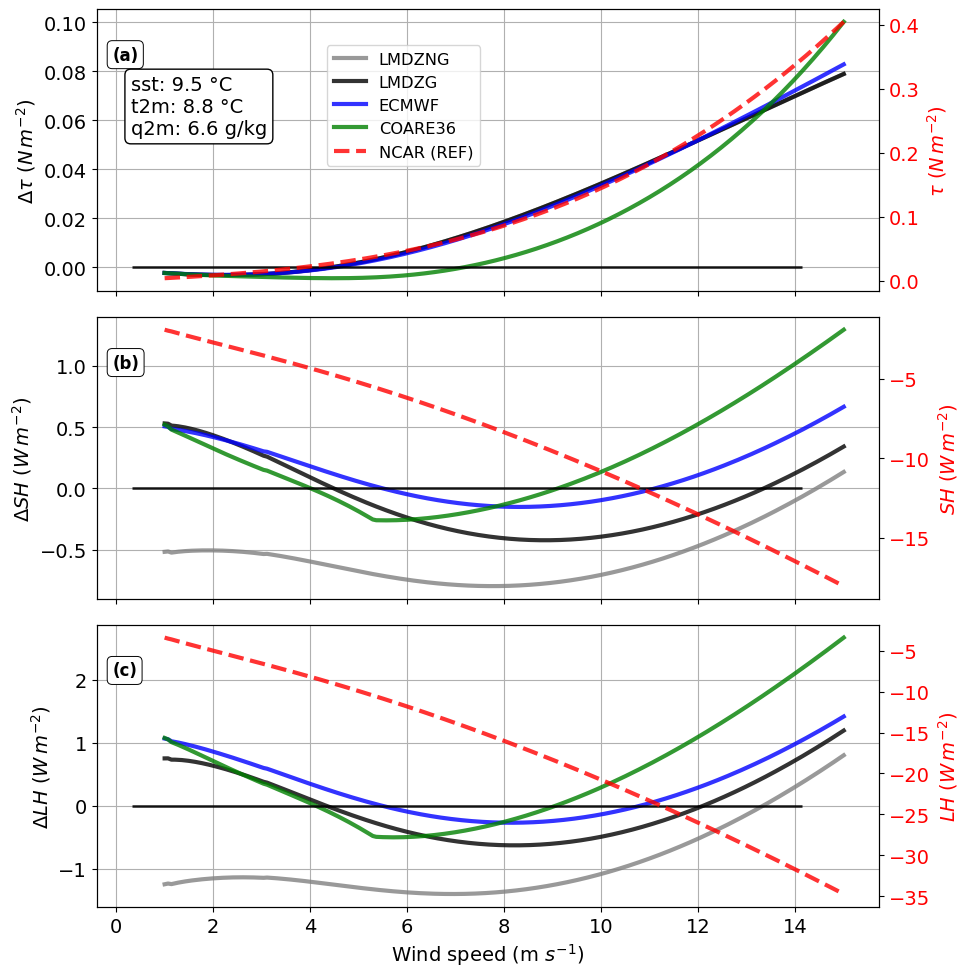

In [7]:
nb_points = int(2e2) ; labels = ['(a)', '(b)', '(c)']

fig, axs = plt.subplots(3,1,figsize=(10,10),sharex=True)

for ax,label in zip(axs,labels):
    ax.grid(True)
    ax.text(0.02, 0.87, label,  zorder= 12,  bbox=dict(facecolor='white', edgecolor='black',boxstyle='round,pad=0.3',linewidth=0.7),
            transform=ax.transAxes,  fontsize=12, fontweight='bold',va='top', ha='left')

axs[0].set_ylabel(r'$\Delta \tau\ (N\,m^{-2})$')
axs[1].set_ylabel(r'$\Delta SH\ (W\,m^{-2})$')
axs[2].set_ylabel(r'$\Delta LH\ (W\,m^{-2})$')
axs[2].set_xlabel('Wind speed (m $s^{-1}$)')

# Offline computation with 'standard' values
sst =  sst_hl
t = t2m_hl
q2m = q2m_hl

gusts = {'NCAR':0, 'ECMWF':0, 'COARE36':0, 'LMDZG':0, 'LMDZNG':0}

text_str = f'sst: {sst:.1f} °C\nt2m: {t:.1f} °C\nq2m: {q2m:.1f} g/kg'
fig.text(0.15, 0.85, text_str, va='bottom', ha='left', bbox=dict(boxstyle="round", facecolor='white'))

spd = np.linspace(1,15,nb_points)
t = t * np.ones(nb_points)
psol = psol * np.ones(nb_points)
sst = sst * np.ones(nb_points)
q2m = q2m * np.ones(nb_points) ; qsurf =  1e3 * q_sat(sst+rt0, psol)

kwargs = dict(spd=spd, T=t, SST=sst,hum=['q',q2m],
    hin=np.array([10*np.ones(nb_points),10*np.ones(nb_points),10*np.ones(nb_points)]),
    hout=10,wl=0,cskin=0,Rl=0, Rs=0, L='Rb')

res = AirSeaFluxCode.AirSeaFluxCode(meth=airseafluxes_bulk['NCAR'],SST_fl = "bulk",gust=0, **kwargs)
res['cq'] = res['ct'] * (np.log(zu / res['zot']) - res['psit'] )/ (np.log(zu / (res['zot'] * f_z0qh_oce)))
t_zu = res['tref'] - rt0 ; q_zu = res['qref']
LH_ref = res['cq'] * rho_air *  (spd+gusts['NCAR']) * Lv * (q_zu - qsurf*f_qsat_oce['NCAR']) / 1e3
SH_ref = res['ct'] * rho_air *  (spd+gusts['NCAR']) * Cp_air * (t_zu - sst)
tau_ref = res['cd'] * rho_air *  (spd+gusts['NCAR']) * spd

c = 'r'
axs[0].twinx().plot(spd, tau_ref , alpha=0.8,c=c,label='NCAR (REF)',linewidth=3,linestyle='--')
plt.gca().tick_params(axis='y', labelcolor=c) ; plt.gca().set_ylabel(r'$\tau\ (N\,m^{-2})$',c=c)
axs[1].twinx().plot(spd, SH_ref, alpha=0.8,c=c,linewidth=3,linestyle='--')
plt.gca().tick_params(axis='y', labelcolor=c) ; plt.gca().set_ylabel(r'$SH\ (W\,m^{-2})$',c=c)
axs[2].twinx().plot(spd, LH_ref, alpha=0.8,c=c,linewidth=3,linestyle='--')
plt.gca().tick_params(axis='y', labelcolor=c) ; plt.gca().set_ylabel(r'$LH\ (W\,m^{-2})$',c=c)


bulk_list_copy = bulk_list.copy()
bulk_list_copy.pop('NCAR')
for (bulk,c) in (bulk_list_copy.items()):

    if 'LMDZG' in bulk:
        Cd, Ch, Ce, zCdN, zChN, zCeN, FM, FH, zri, tau, SH, LH, q_zu, t_zu = turb_lmdzng(zt=10,sst=sst, t_zt=t, ssq=qsurf/1e3, q_zt=q2m/1e3, U_zu=spd,nb_iter=3,gusts=True)
        # LH = -LH ; SH = -SH
        tau = tau /spd * (spd+gusts[bulk]) ; LH = LH /spd * (spd+gusts[bulk]) ; SH = SH / spd * (spd+gusts[bulk])
    elif 'LMDZNG' in bulk:
        Cd, Ch, Ce, zCdN, zChN, zCeN, FM, FH, zri, tau, SH, LH, q_zu, t_zu = turb_lmdzng(zt=10,sst=sst, t_zt=t, ssq=qsurf/1e3, q_zt=q2m/1e3, U_zu=spd,nb_iter=3,gusts=False) 
        tau = tau /spd * (spd+gusts['LMDZG'])
        # LH = -LH ; SH = -SH 
    else:
        gust = [1, 1.2, 600, 0.5] if bulk == 'COARE36' else [4, 1, 1000, 0.01]
        res = AirSeaFluxCode.AirSeaFluxCode(meth=airseafluxes_bulk[bulk],SST_fl = "skin", gust=gust,**kwargs)
        res['cq'] = res['ct'] * (np.log(zu / res['zot']) - res['psit'] )/ (np.log(zu / (res['zot'] * f_z0qh_oce)))   
        t_zu = res['tref'] - rt0 ; q_zu = res['qref']

        LH = res['cq'] * rho_air * (spd+gusts[bulk]) * Lv * (q_zu - qsurf*f_qsat_oce[bulk]) / 1e3
        SH = res['ct'] * rho_air *  (spd+gusts[bulk]) * Cp_air * (t_zu - sst)
        tau = res['cd'] * rho_air *  (spd+gusts[bulk]) * spd

    axs[0].plot(spd, tau - tau_ref, alpha=0.8,c=c,label=bulk,linewidth=3)
    axs[1].plot(spd, SH - SH_ref, alpha=0.8,c=c,linewidth=3)
    axs[2].plot(spd, LH - LH_ref, alpha=0.8,c=c,linewidth=3)

xmin, xmax = axs[2].get_xlim() ; xmin = 1.1* xmin ; xmax=0.9*xmax
axs[0].hlines(0,xmin, xmax ,color='k',linewidth=1.8,alpha=0.9,linestyle='-')
axs[1].hlines(0,xmin, xmax ,color='k',linewidth=1.8,alpha=0.9,linestyle='-')
axs[2].hlines(0,xmin, xmax ,color='k',linewidth=1.8,alpha=0.9,linestyle='-')

leg = fig.legend(loc='upper right', bbox_to_anchor=(0.5, 0.9), bbox_transform=axs[0].transAxes, fontsize='small')
    
# Final plot options
#-------------------------------------
plt.tight_layout()
title = 'Fluxes_wind_HighLatitudes'
# plt.title(title)
plt.savefig(save_path+title+'.png')
     

# Fig 2 (AMOC matrix)

NCAR
LMDZNG
LMDZG
ECMWF
COARE36


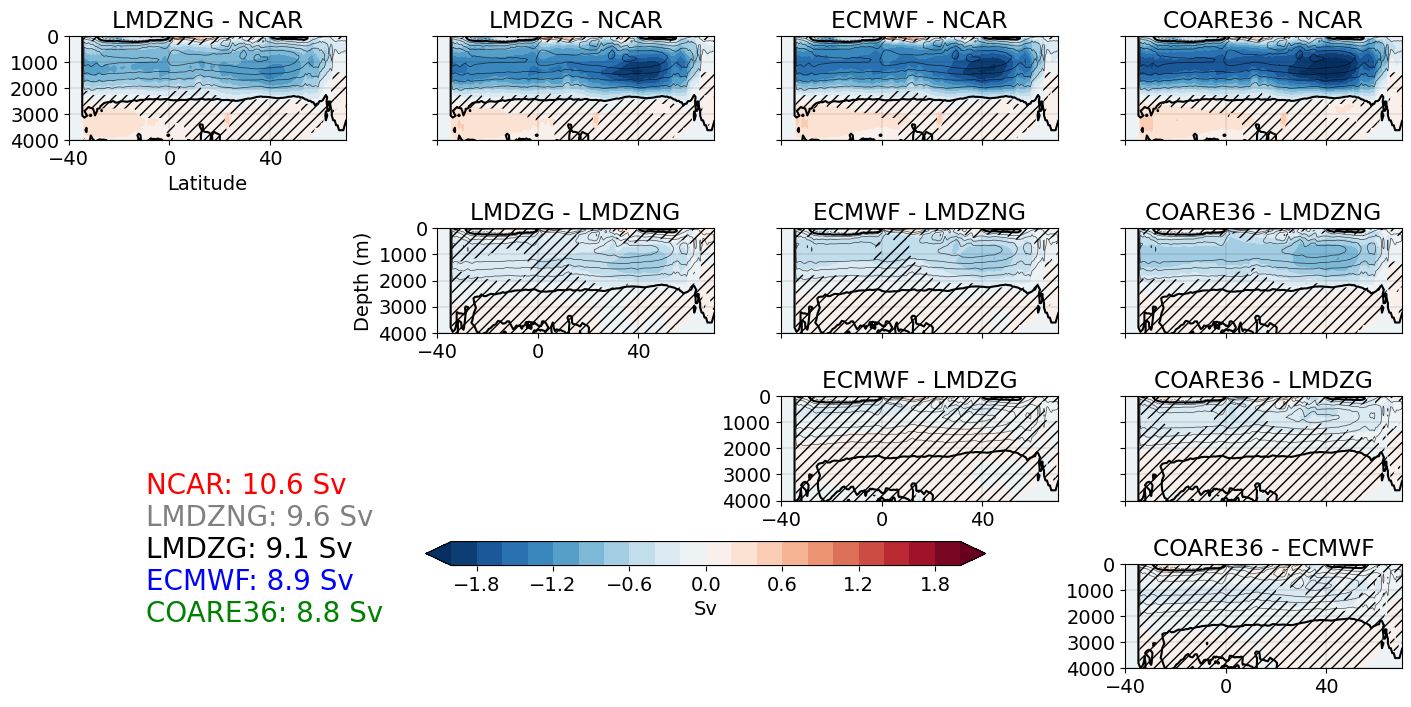

In [16]:
fig, axes = plt.subplots(len(bulk_list), len(bulk_list) - 1, figsize=(14, 8), sharex=True, sharey=True)
config = 'IPSLCM71' ; realm = 'OCE' ; levels = np.round(np.linspace(-2,2,21),2)
cmap = 'RdBu_r' ; variable = 'msftyz_atl' ; nb_years = 100

ds = xr.open_dataset('CM71/CM71_TS_2250_2299/CM71NCAR_18500101_22991231_1M_'+variable+'.nc',decode_times=False)[variable].isel(x=0)
lat, depth = ds.nav_lat, ds.depthw
bulk_list_copy = bulk_list.copy()
bulk_list_copy.pop('NCAR')

for i, bulk1 in enumerate(bulk_list):
    print(bulk1)
    ds1 = xr.open_dataset('CM71/CM71_TS_2250_2299/CM71'+bulk1+'_18500101_22991231_1M_'+variable+'.nc',decode_times=False)[variable].isel(x=0)[-12*nb_years:]
    for j, bulk2 in enumerate(bulk_list_copy):
        if j >= i:
            ax = axes[i, j] ; ax.patch.set_edgecolor('gray')
            ax.set_xlim(-40, 70) ; ax.set_ylim(4000, 0) ; ax.set_yticks(np.arange(0, 5000, 1000)) ; ax.set_xticks(np.arange(-40, 80, 40))
            ax.grid(color='k', linestyle='-', linewidth=0.1) ; ax.set_title(bulk2 + ' - ' + bulk1)
            if j == i:
                ax.tick_params(labelbottom=True, labelleft=True)

            # Load the time series
            ds2 = xr.open_dataset('CM71/CM71_TS_2250_2299/CM71'+bulk2+'_18500101_22991231_1M_'+variable+'.nc',decode_times=False)[variable].isel(x=0)[-12*nb_years:]

            img = ax.contourf(lat, depth, (ds2 - ds1).mean('time_counter'), cmap=cmap, levels=levels, extend='both')
            contour = ax.contour(lat, depth, ds1.mean('time_counter'), colors='k',
                                levels=np.arange(-2, 12, 2),linewidths=0.5, alpha=0.7)
            contour0 = ax.contour(lat, depth, ds1.mean('time_counter'), colors='k',
                        levels=[0],linewidths=1.5, alpha=1)
            # ax.clabel(contour, colors=['k'], inline=True, fmt='{:3.0f} '.format, fontsize='small')

            # Plot the hatching on the masked region
            p_values = scipy.stats.ttest_ind(ds1.values, ds2.values, axis=0, equal_var=False).pvalue
            p_values_da = xr.DataArray(p_values, dims=('depthw', 'y'), coords={'depthw': ds1.coords['depthw'], 'y': ds1.coords['y']})
            mask = p_values_da > 0.05
            hatch = ax.contourf(lat, depth,mask, levels=[0.5, 1.5], colors='none', hatches=['///'])

        else:
            fig.delaxes(axes[i, j]) 
            
axes[0,0].set_xlabel('Latitude', fontsize=14)
axes[1,1].set_ylabel('Depth (m)', fontsize=14)

max_val = dict()
for bulk,c in bulk_list.items():
    ds1 = xr.open_dataset('CM71/CM71_TS_2250_2299/CM71'+bulk+'_18500101_22991231_1M_'+variable+'.nc',decode_times=False
                          )[variable].isel(x=0)[-12*nb_years:].where(depth>200,drop=True)
    max_val[bulk] = ds1.mean('time_counter').max().values

# Add text to plot
for i, (bulk, value) in enumerate(max_val.items()):
    fig.text(0.1, 0.4 - i * 0.04, f"{bulk}: {value:.1f}"+' Sv', ha='left', va='center', 
            fontsize=20, color=bulk_list[bulk])

# Final plot othptions
#-------------------------------------
title = 'AMOC matrix ' + config
cbar_ax = fig.add_axes([0.3, 0.3, 0.4, 0.03])
fig.colorbar(img, orientation='horizontal', cax=cbar_ax, label="Sv")
plt.savefig(save_path+title+'.png')

# Fig 3 (MLD)

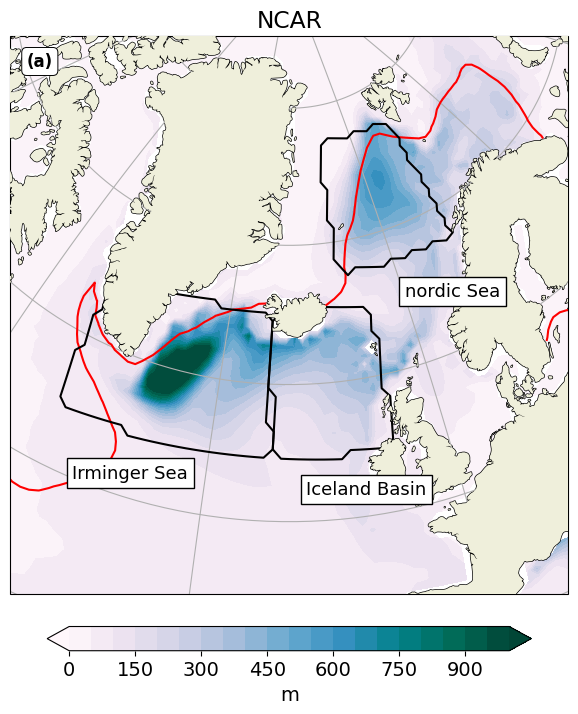

In [6]:
config = 'IPSLCM71';realm = 'OCE';variable = 'pycndep';bulk_ref = 'NCAR' ; labels = ['(a)' ,'(b)','(c)','(d)']

# Plot config
#-------------------------------------
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.Orthographic (central_longitude=-20, central_latitude=65)},figsize=(7,7))
cmap = 'PuBuGn'; levels = np.linspace(0,1,21) *1e3

ax.set_title(bulk_ref) ;width = 0.35
ax.set_xlim (-Rearth*width, Rearth*width) ; ax.set_ylim (-Rearth*width, Rearth*width)
ax.coastlines(); ax.gridlines(draw_labels=False); ax.add_feature(cartopy.feature.LAND,zorder=10)
ax.patch.set_edgecolor('gray')
ax.text(0.03, 0.97, '(a)',  zorder= 12,  bbox=dict(facecolor='white', edgecolor='black',boxstyle='round,pad=0.3',linewidth=0.7),
            transform=ax.transAxes,  fontsize=12, fontweight='bold',va='top', ha='left')

# Plot the data
ds1 = load_data_ext(config, realm, bulk, variable).max('month') ; lon = nemo.fixed_lon(ds1.nav_lon) ; lat = ds1.nav_lat
ds1 = np.clip(ds1,0,levels.max())
img = ax.contourf(lon,lat,ds1,transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,
                extend='both',add_colorbar=False)

# Plot ice levels
ice1 = load_data_ext(config,realm,bulk_ref,'siconc').max(dim='month')
ax.contour(lon,lat,ice1,transform=ccrs.PlateCarree(),levels=[0.15], colors=bulk_list[bulk_ref])

fig.colorbar (img, orientation='horizontal', ax=ax, label="m",shrink=0.7,pad=0.05)

# Add DWF masks to the last ax
img = ax.contour(lon,lat,iceland,levels=[0],transform=ccrs.PlateCarree(),colors='k')
ax.text(-18, 52, 'Iceland Basin', transform=ccrs.PlateCarree(), fontsize=13, zorder=10, bbox=dict(facecolor='white', edgecolor='k'))
img = ax.contour(lon,lat,nordic,levels=[0],transform=ccrs.PlateCarree(),colors='k')
ax.text(0, 65, 'nordic Sea', transform=ccrs.PlateCarree(), fontsize=13, zorder=10, bbox=dict(facecolor='white', edgecolor='k'))
img = ax.contour(lon,lat,irminger,levels=[0],transform=ccrs.PlateCarree(),colors='k')
ax.text(-45, 50, 'Irminger Sea', transform=ccrs.PlateCarree(), fontsize=13, zorder=10, bbox=dict(facecolor='white', edgecolor='k'))
# img = ax.contour(lon,lat,labrador,levels=[0],transform=ccrs.PlateCarree(),colors='k')
# ax.text(-82, 65, 'Labrador Sea', transform=ccrs.PlateCarree(), fontsize=13, zorder=10, bbox=dict(facecolor='white', edgecolor='k'))

# Final plot options
#-------------------------------------
title = 'MLD in the Atlantic for NCAR' +config
plt.savefig(save_path+title+'.png')


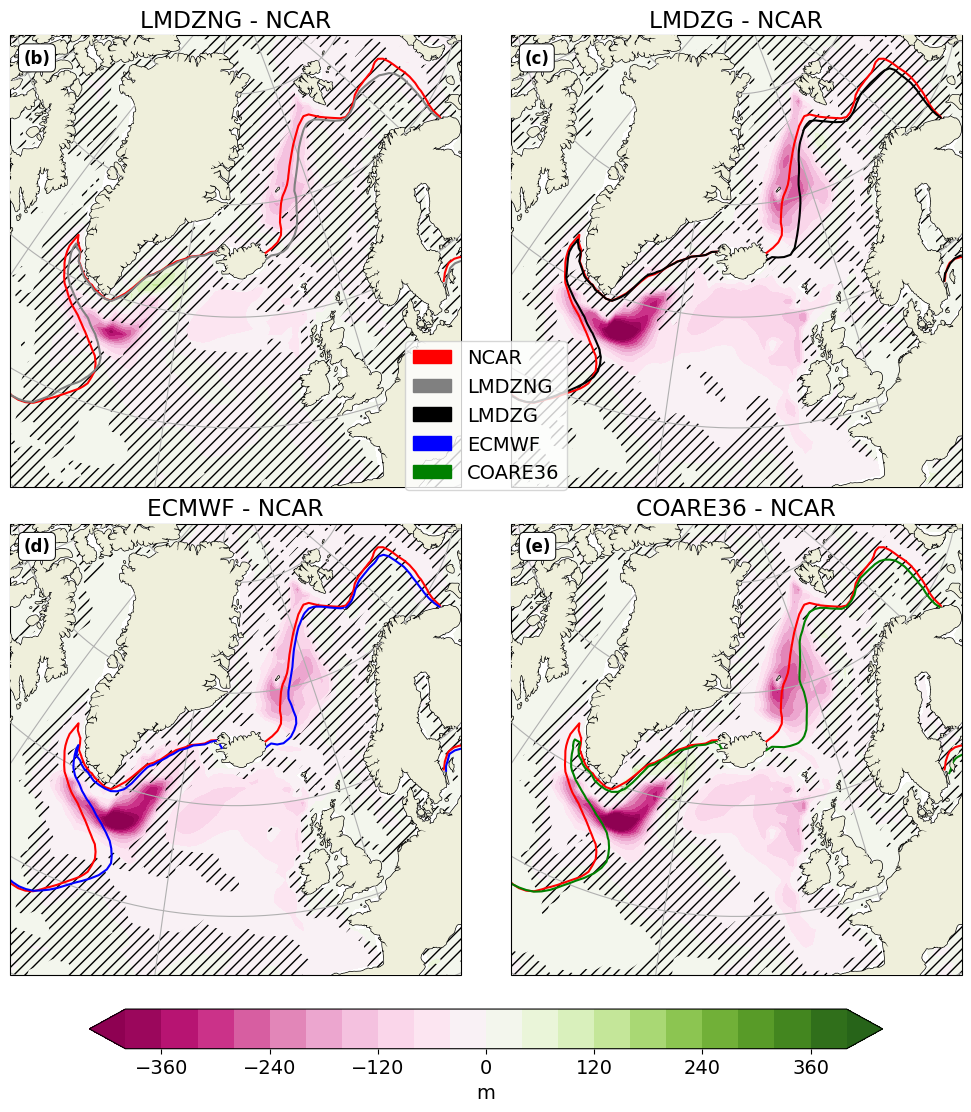

In [7]:
config = 'IPSLCM71';realm = 'OCE';variable = 'pycndep';bulk_ref = 'NCAR'

# Plot config
#-------------------------------------
fig, axs = plt.subplots(2, 2, subplot_kw={'projection':ccrs.Orthographic (central_longitude=-20, central_latitude=65)},figsize=(10,11))
cmap = 'PiYG'; levels = np.linspace(-1,1,21) *4e2
labels = ['(b)','(c)','(d)','(e)']
bulk_list_temp = bulk_list.copy() ; bulk_list_temp.pop(bulk_ref)
                                      
# # Open datasets and concatenate them along the time_counter dimension
ds1 = xr.concat([
    xr.open_dataset('CM71/CM71_TS_2200_2249/CM71'+bulk_ref+'_22000101_22491231_1M_'+variable+'.nc'),  
    xr.open_dataset('CM71/CM71_TS_2250_2299/CM71'+bulk_ref+'_22500101_22991231_1M_'+variable+'.nc')
], dim="time_counter")[variable]

# Convert time_counter to datetime and extract the year
ds1['time_counter'] = xr.cftime_range(start='2200', periods=ds1.sizes['time_counter'], freq='M')
ds1 = ds1.groupby('time_counter.year').max('time_counter')

for (bulk, c),ax,label in zip(bulk_list_temp.items(),axs.flatten(),labels):
    ax.set_title(bulk + ' - ' + bulk_ref) ; width = 0.35
    ax.set_xlim (-Rearth*width, Rearth*width) ; ax.set_ylim (-Rearth*width, Rearth*width)
    ax.coastlines(); ax.gridlines(draw_labels=False); ax.add_feature(cartopy.feature.LAND,zorder=10)
    ax.text(0.03, 0.97, label,  zorder= 12,  bbox=dict(facecolor='white', edgecolor='black',boxstyle='round,pad=0.3',linewidth=0.7),
            transform=ax.transAxes,  fontsize=12, fontweight='bold',va='top', ha='left')
    

    # Load time series
    # ======================
    ds2 = xr.concat([
        xr.open_dataset('CM71/CM71_TS_2200_2249/CM71'+bulk+'_22000101_22491231_1M_'+variable+'.nc'),  
        xr.open_dataset('CM71/CM71_TS_2250_2299/CM71'+bulk+'_22500101_22991231_1M_'+variable+'.nc')
    ], dim="time_counter")[variable]

    # Convert time_counter to datetime and extract the year
    ds2['time_counter'] = xr.cftime_range(start='2200', periods=ds2.sizes['time_counter'], freq='M')
    ds2 = ds2.groupby('time_counter.year').max('time_counter')

    diff = (ds2 - ds1)
    mean_diff = diff.mean('year')

    # Perform the binomial test in a vectorized manner and masked values below threshold
    p_values = scipy.stats.ttest_ind(ds1.values, ds2.values, axis=0, equal_var=False).pvalue
    # p_values = np.vectorize(lambda k: scipy.stats.ttest_ind(ds1, ds2, axis=0, equal_var=False).pvalue)#(n_successes)
    # p_values = np.vectorize(lambda k: scipy.stats.binomtest(k, n_trials, p=0.5, alternative='two-sided').pvalue)(n_successes)
    p_values_da = xr.DataArray(p_values, dims=('y', 'x'), coords={'x': ds1.coords['x'], 'y': ds1.coords['y']})
    mask = p_values_da > 0.05
    lon = nemo.fixed_lon(mean_diff.nav_lon) ; lat = mean_diff.nav_lat

    # Plot the data
    img = ax.contourf(lon,lat,mean_diff,transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,
                    extend='both',add_colorbar=False)

    # Plot the hatching on the masked region
    # hatch = ax.contourf(lon, lat, ~mask, levels=[0.5, 1.5],hatches=['//'], transform=ccrs.PlateCarree(),alpha=0.4)
    hatch = ax.contourf(lon, lat, mask, levels=[0.5, 1.5], transform=ccrs.PlateCarree(), colors='none', hatches=['///'], linewidth=0)
    # ax.contourf(lat, depth, ~mask, levels=[0.5, 1.5], colors='none', hatches=['///'], linewidth=0)
    
    # Plot ice levels
    ice1 = load_data_ext(config,realm,bulk_ref,'siconc').max(dim='month')
    ice2 = load_data_ext(config,realm,bulk,'siconc').max(dim='month')
    ax.contour(lon,lat,ice1,transform=ccrs.PlateCarree(),levels=[0.15], colors=bulk_list[bulk_ref])
    ax.contour(lon,lat,ice2,transform=ccrs.PlateCarree(),levels=[0.15], colors=bulk_list[bulk])

fig.colorbar (img, orientation='horizontal', ax=axs[-1,:], label="m",pad=0.07,shrink=0.8)

# Add legend 
handles = [plt.Rectangle((0.1,0.1),0.2,0.05, color=color) for color in bulk_list.values()]
labels =  bulk_list.keys()
fig.legend(handles, labels,loc='lower center', bbox_to_anchor=(0.5, 0.55), ncol=1)

# Final plot options
#-------------------------------------
title = variable + ' ' +config#+ ' Atlantic'
# plt.suptitle(title)
plt.savefig(save_path+title+'.png')


# Fig 4 (T-S diagram)

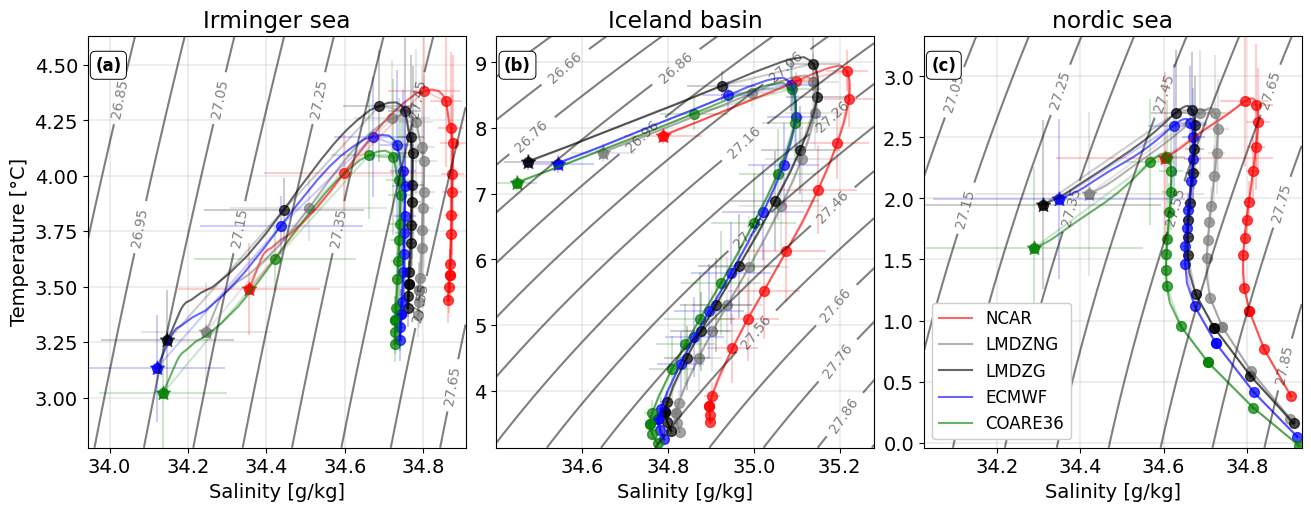

In [15]:
config = 'IPSLCM71' ; realm = 'OCE' ; max_depth = 1500
labels = ['(a)', '(b)', '(c)']

fig, axes = plt.subplots(1,3,figsize=(13,5))
months = load_data_ext(config,realm,'NCAR','tos').month

for region_mask,name,ax,label in zip([irminger,iceland,nordic],['Irminger sea','Iceland basin','nordic sea'],axes,labels):

    ax.text(0.02, 0.95, label,  zorder= 12,  bbox=dict(facecolor='white', edgecolor='black',boxstyle='round,pad=0.3',linewidth=0.7),
                transform=ax.transAxes,  fontsize=12, fontweight='bold',va='top', ha='left')

    target_depths = np.arange(0,max_depth,100)
    depth = load_data_ext(config,realm,bulk,'thetao').where(region_mask,drop=True).isel(month=0).mean('x').mean('y').depth
    indices = [np.abs(depth - target).argmin() for target in target_depths]
    temperature_max = -10 ; temperature_min = 50
    salinity_max = -10 ; salinity_min = 50

    for bulk, color in bulk_list.items():
 
        # max_month_mask = load_data_ext('IPSLCM71',realm,bulk,'mldr10_1').fillna(0).argmax('month')
        mask = region_mask #& (load_data_ext(config,realm,bulk,'siconc').isel(month=max_month_mask) < 0.15)
        temperature = load_data_ext(config,realm,bulk,'thetao').where(mask,drop=True).where(depth<max_depth).sel(month=months.isin([12, 1, 2])).mean('month')
        salinity = load_data_ext(config,realm,bulk,'so').where(mask,drop=True).where(depth<max_depth).sel(month=months.isin([12, 1, 2])).mean('month')
        # mld = load_data_ext(config,realm,bulk,'pycndep').max('month').where(mask,drop=True).mean('x').mean('y')

        temperature_std = temperature.std('x').std('y')
        salinity_std = salinity.std('x').std('y')
        temperature = temperature.mean('x').mean('y')
        salinity = salinity.mean('x').mean('y')

        # ax.errorbar(salinity, temperature, xerr=salinity_std, yerr=temperature_std, color=color, alpha=0.2)
        ax.errorbar(salinity[indices],temperature[indices], xerr=salinity_std[indices], yerr=temperature_std[indices], color=color, alpha=0.2)
        ax.plot(salinity,temperature,color=color,label=bulk,alpha=0.6)
        scatter = ax.scatter(salinity[indices],temperature[indices],color=color,s=50,alpha=0.7)
        # ax.scatter(salinity.sel(depth=mld,method='nearest'),temperature.sel(depth=mld,method='nearest'),color=color,s=110,alpha=0.7,marker='D')
        ax.scatter(salinity.sel(depth=0,method='nearest'),temperature.sel(depth=0,method='nearest'),color=color,s=110,alpha=0.7,marker='*')

        # Make a contour with isodensity lines
        temperature_max = max( (temperature[indices] + temperature_std[indices]).max().values, temperature_max)
        temperature_min = min( (temperature[indices] - temperature_std[indices]).min().values, temperature_min)
        salinity_max = max( (salinity[indices] + salinity_std[indices]).max().values, salinity_max)
        salinity_min = min( (salinity[indices] - salinity_std[indices]).min().values, salinity_min)

    temperature_1D = np.linspace(temperature_min, temperature_max, 100)
    salinity_1D = np.linspace(salinity_min, salinity_max, 100)

    salinity_2D, temperature_2D = np.meshgrid(salinity_1D,temperature_1D)
    rho = gsw.density.rho(salinity_2D, temperature_2D,0) - 1000
    contour = ax.contour(salinity_2D,temperature_2D,rho,levels=np.round(np.arange(np.min(rho),np.max(rho),0.1),2),colors='k',alpha=0.5)
    ax.clabel(contour, inline=True, fontsize=10)

    ax.set_title(name)
    ax.set_facecolor('White')
    if ax == axes[0]:
        ax.set_ylabel ("Temperature [°C]")
    ax.set_xlabel ("Salinity [g/kg]")
    ax.grid (color='k', linestyle='-', linewidth=0.1)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),loc='best',facecolor='White',framealpha=1,fontsize=12)
# fig.legend(by_label.values(), by_label.keys(),loc='center right', bbox_to_anchor=(0.5, -0.07), ncol=1,fontsize=12)

plt.savefig(save_path+'TS_diagram.png')

# Fig 5 (surface currents SST SSS)

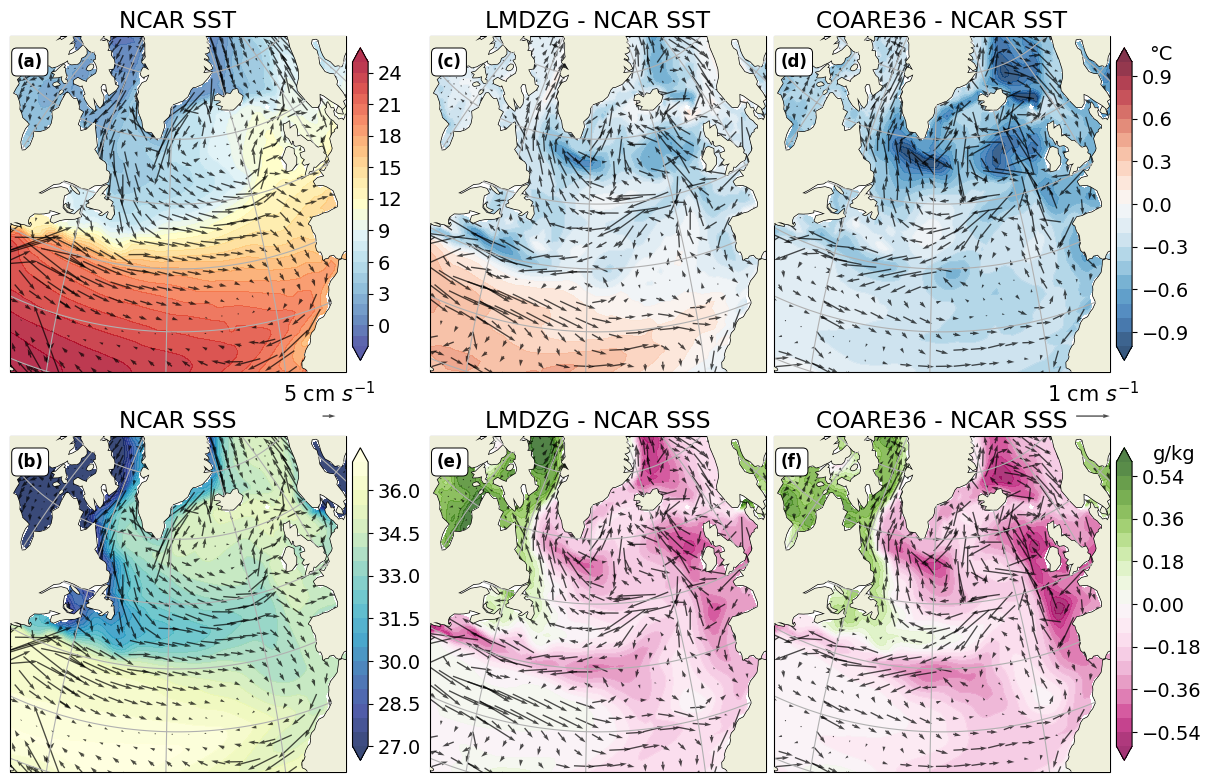

In [14]:
config = 'IPSLCM71';realm = 'OCE';bulk_ref = 'NCAR'; variable = 'streamfunction_U_V' ; imonth=1
labels = ['(a)', '(c)', '(d)', '(b)', '(e)', '(f)'] ; scale = 3

fig, axs = plt.subplots( 2, 3, subplot_kw={'projection': ccrs.Orthographic(central_longitude=-38, central_latitude=50)}, figsize=(12, 8))

# axs = axs.ravel()  # flatten 2D grid into 1D array
for ax, label in zip(axs.ravel(), labels):
    ax.coastlines() ; ax.gridlines(draw_labels=False); ax.add_feature(cartopy.feature.LAND, zorder=10)
    ax.text( 0.02, 0.95, label, transform=ax.transAxes, va='top', ha='left',zorder= 20,
        fontweight='bold', fontsize=12,  bbox=dict( facecolor='white', edgecolor='black',  boxstyle='round,pad=0.3', linewidth=0.7 )  )

    # Orthographic extent
    width = 0.45
    ax.set_xlim(-Rearth * width, Rearth * width)
    ax.set_ylim(-Rearth * width, Rearth * width)

# Ref values
ue_ref = load_data_ext ('IPSLCM71', 'OCE',bulk_ref, 'uos','T','U').mean('month').coarsen(x=scale, y=scale,boundary='trim').mean()
vn_ref = load_data_ext('IPSLCM71', 'OCE',bulk_ref, 'vos','T','V').mean('month').coarsen(x=scale, y=scale,boundary='trim').mean()
uv_ref = np.sqrt (ue_ref*ue_ref + vn_ref*vn_ref)
tos_ref = load_data_ext ('IPSLCM71', 'OCE',bulk_ref, 'tos').mean('month')
# tos_ref = xr.where(tos_ref > 21, 23, tos_ref)  # Remove erroneous values
sos_ref = load_data_ext ('IPSLCM71', 'OCE',bulk_ref, 'sos').mean('month')
# sos_ref = xr.where(sos_ref > 37, 37, sos_ref)  # Remove erroneous values
lon,lat = nemo.fixed_lon(sos_ref.nav_lon),sos_ref.nav_lat

for ax, title in zip(axs[:,0], [bulk_ref + ' SST', bulk_ref + ' SSS']):
    ax.set_title(title)
    levels = np.arange(-2,26,1) if 'SST' in title else np.arange(27,37.5,0.5) ; cmap = 'RdYlBu_r' if 'SST' in title else 'YlGnBu_r'
    data = tos_ref if 'SST' in title else sos_ref
    img = ax.contourf(lon, lat, data, levels=levels, cmap=cmap, transform=ccrs.PlateCarree(), zorder=1, extend='both',alpha=0.8)
    cbar = plt.colorbar(img, orientation='vertical', pad=0.02,shrink=0.8)
    mver = ax.quiver ( ue_ref.nav_lon.values, ue_ref.nav_lat.values, ue_ref.values, vn_ref.values,pivot='tail', scale=1.3, width=4E-3,alpha=0.7,
        transform=ccrs.PlateCarree (central_longitude=0))

ax.quiverkey(mver, 0.95, 1.06, U=0.05, label="5 cm $s^{-1}$",zorder=21,fontproperties={'size': 15})

for ax_rows,bulk in zip(axs.T[1:],['LMDZG','COARE36']):

    ue =   load_data_ext ('IPSLCM71', 'OCE',bulk, 'uos','T','U').mean('month').coarsen(x=scale, y=scale,boundary='trim').mean() - ue_ref
    vn =  load_data_ext('IPSLCM71', 'OCE',bulk, 'vos','T','V').mean('month').coarsen(x=scale, y=scale,boundary='trim').mean() - vn_ref
    tos = load_data_ext ('IPSLCM71', 'OCE',bulk, 'tos').mean('month') - tos_ref
    sos = load_data_ext ('IPSLCM71', 'OCE',bulk, 'sos').mean('month') - sos_ref

    ax = ax_rows[0] ; ax.set_title(bulk + ' - ' + bulk_ref + ' SST')
    img_tos = ax.contourf(lon, lat, tos, levels=np.linspace(-1,1,21), cmap='RdBu_r', transform=ccrs.PlateCarree(), extend='both',alpha=0.8)
    mver = ax.quiver ( ue.nav_lon.values, ue.nav_lat.values, ue.values, vn.values,pivot='tail', scale=0.1, width=4E-3,alpha=0.7,
        transform=ccrs.PlateCarree (central_longitude=0))

    ax = ax_rows[1] ; ax.set_title(bulk + ' - ' + bulk_ref + ' SSS')
    img_sos = ax.contourf(lon, lat, sos, levels=np.linspace(-0.6,0.6,21), cmap='PiYG', transform=ccrs.PlateCarree(), extend='both',alpha=0.8)
    mver = ax.quiver ( ue.nav_lon.values, ue.nav_lat.values, ue.values, vn.values,pivot='tail', scale=0.1, width=4E-3,alpha=0.7,
        transform=ccrs.PlateCarree (central_longitude=0))

axs[1,2].quiverkey(mver, 0.95, 1.06, U=0.01, label="1 cm $s^{-1}$",zorder=21,fontproperties={'size': 15})
cbar = fig.colorbar(img_tos, ax=axs[0,-1], orientation='vertical', pad=0.02,shrink=0.8)
cbar.set_label("°C", rotation=0, labelpad=-20, y=1.06, ha='center')
cbar = fig.colorbar(img_sos, ax=axs[1,-1], orientation='vertical', pad=0.02,shrink=0.8)
cbar.set_label("g/kg", rotation=0, labelpad=-20, y=1.06, ha='center')

title = 'SurfaceCurrent'
plt.savefig(save_path+title+'.png')


# Fig 6 (Density flxues)

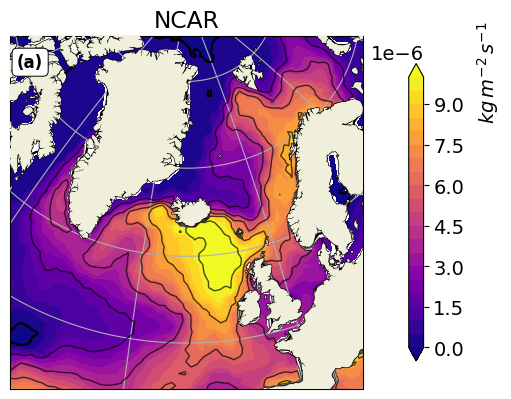

In [12]:
config = 'IPSLCM71';realm = 'OCE';bulk_ref = 'NCAR'

labels = ['(a)']


fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.Orthographic (central_longitude=-20, central_latitude=65)},figsize=(5,4))

# Density flux
# ======================
Q0 = load_data_ext(config,realm,bulk_ref,'qt_oce')
S0 = load_data_ext(config,realm,bulk_ref,'sos')
E_P = load_data_ext(config,realm,bulk_ref,'emp_oce')
SST = load_data_ext(config,realm,bulk_ref,'tos')
Cp = gsw.cp_t_exact(S0,SST,0) ; alpha = gsw.alpha(S0,SST,0) ; beta = gsw.beta(S0,SST,0)
B0_ref = (- alpha * Q0 /Cp + beta * E_P * S0 ).isel(month=[0, 1, 11]).mean('month')
lon,lat = nemo.fixed_lon(Q0.nav_lon),Q0.nav_lat
i = 0

ax.text(
    0.02, 0.95, # Coordinates relative to the axis (0,0) is bottom-left and (1,1) is top-right
    labels[i],  zorder= 12, 
    bbox=dict(
    facecolor='white',  # White background
    edgecolor='black',  # Black border
    boxstyle='round,pad=0.3',  # Rounded box with padding
    linewidth=0.7), # Border thickness)
    transform=ax.transAxes,  fontsize=12,  # Font size
    fontweight='bold',va='top', ha='left')
i+=1 ; width = 0.35
ax.set_title(bulk_ref)
ax.set_xlim (-Rearth*width, Rearth*width) ; ax.set_ylim (-Rearth*width, Rearth*width)
ax.coastlines()
ax.gridlines(draw_labels=False)
ax.add_feature(cartopy.feature.LAND, zorder=10)

img_df = ax.contourf(lon,lat,B0_ref,transform=ccrs.PlateCarree(),
            levels=np.linspace(0,1,21) * 1e-5 ,cmap='plasma',extend='both',add_colorbar=False)
contour = ax.contour(lon,lat,B0_ref.fillna(0)*1e6,transform=ccrs.PlateCarree(),
        levels= 10*np.linspace(-1,1,11),colors='k',alpha=0.7,linewidths=1)
contour0 = ax.contour(lon,lat,B0_ref.fillna(0)*1e6,transform=ccrs.PlateCarree(),
    levels= [0],colors='k',alpha=1,linewidths=1.5)

cbar = fig.colorbar(img_df,ax=ax,orientation='vertical',shrink=0.8,pad=0.02)
cbar.set_label(r'$kg\,m^{-2}\,s^{-1}$', rotation=90, labelpad=8, x = 0.9, y=1.02, ha='center')

# Final plot options
#-------------------------------------
title = 'DensityFluxes_'+bulk_ref
plt.savefig(save_path+title+'.png')

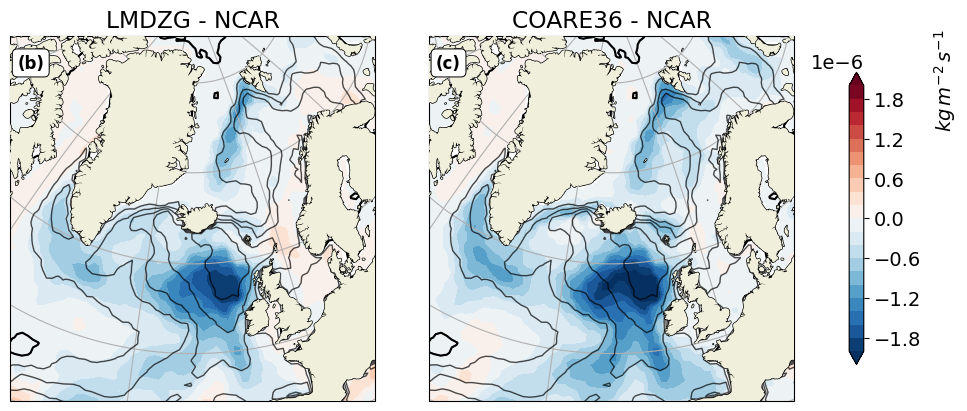

In [13]:
config = 'IPSLCM71';realm = 'OCE';bulk_ref = 'NCAR'; variable = 'streamfunction_U_V' ; imonth=1

labels = ['(b)', '(c)', '(d)', '(e)', '(f)']


fig, axs = plt.subplots(1, 2, subplot_kw={'projection': ccrs.Orthographic (central_longitude=-20, central_latitude=65)},figsize=(10,4))

# Density flux
# ======================
Q0 = load_data_ext(config,realm,bulk_ref,'qt_oce')
S0 = load_data_ext(config,realm,bulk_ref,'sos')
E_P = load_data_ext(config,realm,bulk_ref,'emp_oce')
SST = load_data_ext(config,realm,bulk_ref,'tos')
Cp = gsw.cp_t_exact(S0,SST,0) ; alpha = gsw.alpha(S0,SST,0) ; beta = gsw.beta(S0,SST,0)
B0_ref = (- alpha * Q0 /Cp + beta * E_P * S0 ).isel(month=[0, 1, 11]).mean('month')
lon,lat = nemo.fixed_lon(Q0.nav_lon),Q0.nav_lat
i = 0

for ax,bulk in zip(axs,['LMDZG','COARE36']):
    
    ax.text(
        0.02, 0.95, # Coordinates relative to the axis (0,0) is bottom-left and (1,1) is top-right
        labels[i],  zorder= 12, 
        bbox=dict(
        facecolor='white',  # White background
        edgecolor='black',  # Black border
        boxstyle='round,pad=0.3',  # Rounded box with padding
        linewidth=0.7), # Border thickness)
        transform=ax.transAxes,  fontsize=12,  # Font size
        fontweight='bold',va='top', ha='left')
    i+=1 ; width = 0.35
    ax.set_title(bulk + ' - ' + bulk_ref)
    ax.set_xlim (-Rearth*width, Rearth*width) ; ax.set_ylim (-Rearth*width, Rearth*width)
    ax.coastlines()
    ax.gridlines(draw_labels=False)
    ax.add_feature(cartopy.feature.LAND, zorder=10)
    Q0 = load_data_ext(config,realm,bulk,'qt_oce')
    S0 = load_data_ext(config,realm,bulk,'sos')
    E_P = load_data_ext(config,realm,bulk,'emp_oce')
    SST = load_data_ext(config,realm,bulk,'tos')
    Cp = gsw.cp_t_exact(S0,SST,0) ; alpha = gsw.alpha(S0,SST,0) ; beta = gsw.beta(S0,SST,0)
    B0 = (- alpha * Q0 /Cp + beta * E_P * S0 ).isel(month=[0, 1, 11]).mean('month')
    
    img_df = ax.contourf(lon,lat,B0-B0_ref,transform=ccrs.PlateCarree(),
                levels=np.linspace(-1,1,21) *2e-6 ,cmap='RdBu_r',extend='both',add_colorbar=False)
    contour = ax.contour(lon,lat,B0_ref.fillna(0)*1e6,transform=ccrs.PlateCarree(),
            levels= 10*np.linspace(-1,1,11),colors='k',alpha=0.7,linewidths=1)
    contour0 = ax.contour(lon,lat,B0_ref.fillna(0)*1e6,transform=ccrs.PlateCarree(),
        levels= [0],colors='k',alpha=1,linewidths=1.5)

cbar = fig.colorbar(img_df,ax=axs,orientation='vertical',shrink=0.8,pad=0.02)
cbar.set_label(r'$kg\,m^{-2}\,s^{-1}$', rotation=90, labelpad=8, x = 0.9, y=1.02, ha='center')

# Final plot options
#-------------------------------------
title = 'DensityFluxes'
plt.savefig(save_path+title+'.png')

# Fig 7 (online fluxes)

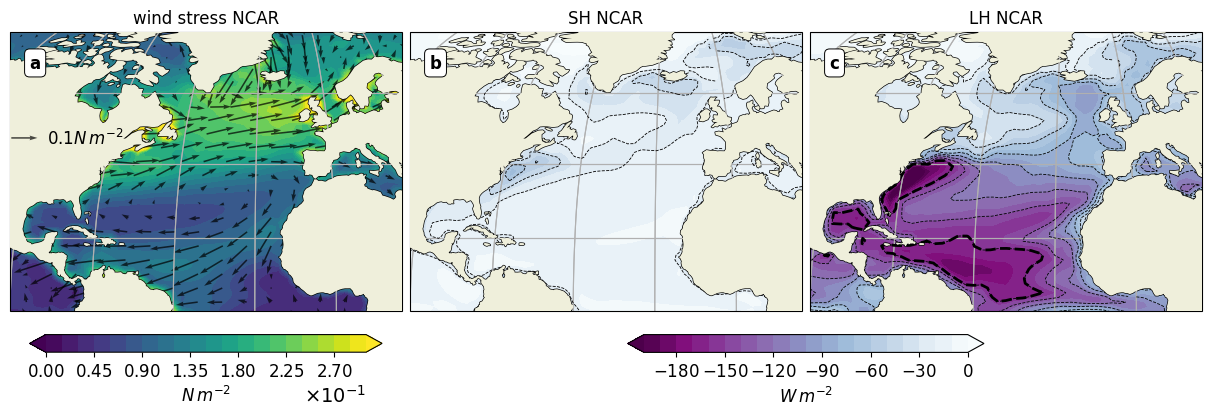

In [8]:
# Configuration and setup
fig, axes = plt.subplots(1, 3, subplot_kw={'projection': ccrs.Robinson(central_longitude=-20)}, figsize=(12, 5))
bulk1, config, realm = 'NCAR', 'IPSLCM71', 'ATM'
outvar = ("tau", "SH", "LH")
labels = [chr(97 + i) for i in range(3)]  # 'a' to 'l'
bulk_list_copy = [bulk for bulk in bulk_list if bulk != bulk1]

# Main plotting loop
img_list = []
for j, (flux, ax) in enumerate(zip(outvar, axes)):
    ax.coastlines(); ax.gridlines(draw_labels=False);ax.gridlines(); ax.add_feature(cartopy.feature.LAND,zorder=10)
    ax.set_extent([-100, 20, 0, 80], crs=ccrs.PlateCarree())  ; ax.set_title(flux.replace('tau','wind stress') + ' '+ bulk1,fontsize=12)
    ax.text(0.05, 0.92, labels[j],  zorder= 12,  bbox=dict(facecolor='white', edgecolor='black',boxstyle='round,pad=0.3',linewidth=0.7),
        transform=ax.transAxes,  fontsize=12, fontweight='bold',va='top', ha='left')
        
    ds = load_data(config, realm, bulk1, gcm_variables[flux + '_' + realm]).mean(dim='month')
    ds_cyc, lon_cyc = add_cyclic_point(ds, coord=ds.lon)
    img = ax.contourf(lon_cyc, ds.lat, ds_cyc, cmap=colormaps_ref[flux], 
                        levels=levels_ref[flux], transform=ccrs.PlateCarree(), extend='both')
    if flux != 'tau':
        contour = ax.contour(ds.lon,ds.lat,ds,transform=ccrs.PlateCarree(),levels=levels_short[flux], colors='k',linewidths=0.6)
        contour = ax.contour(ds.lon,ds.lat,ds,transform=ccrs.PlateCarree(),levels=[levels_short[flux][np.argmax(np.abs(levels_short[flux]))]],
                            colors='k',linewidths=2)  
    img_list.append(img)

# Add quiver for tau
ax = axes[0]
taux = load_data_ext(config, realm, bulk1,'taux').mean(dim='month').coarsen(lon= 3, lat =3, boundary='trim').mean()
tauy = load_data_ext(config, realm, bulk1,'tauy').mean(dim='month').coarsen(lon= 3, lat =3, boundary='trim').mean()
lon2d, lat2d = np.meshgrid(taux.lon, taux.lat)
quiver = ax.quiver(lon2d, lat2d, taux.values, tauy.values, transform=ccrs.PlateCarree(),scale=1.5,width=4E-3,alpha=0.7)
quiverkey = ax.quiverkey(quiver,0.07, 0.62, 0.1, r'$0.1 N\,m^{-2}$', labelpos='E',
                            coordinates='axes',zorder = 11,fontproperties={'size':12})
# Add colorbars
cbar = fig.colorbar(img_list[0], ax=axes[0], orientation='horizontal', location='bottom',shrink=0.9,pad=0.05)
cbar.set_label(r'$N\,m^{-2}$', fontsize=12)  # Add this line to set the label with units
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((-1, 3))
cbar.ax.tick_params(labelsize=12)
cbar.update_ticks()

cbar = fig.colorbar(img_list[1], ax=axes[-2:], orientation='horizontal', location='bottom',shrink=0.45,pad=0.05)
cbar.set_label(r'$W\,m^{-2}$', fontsize=12)  # Add this line to set the label with units
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((-1, 3))
cbar.ax.tick_params(labelsize=12)
cbar.update_ticks()

# Save and show
title = f"Fluxes {bulk1} {config}"
# plt.suptitle(title)
plt.savefig(f"{save_path}{title}.png")



LMDZG
COARE36


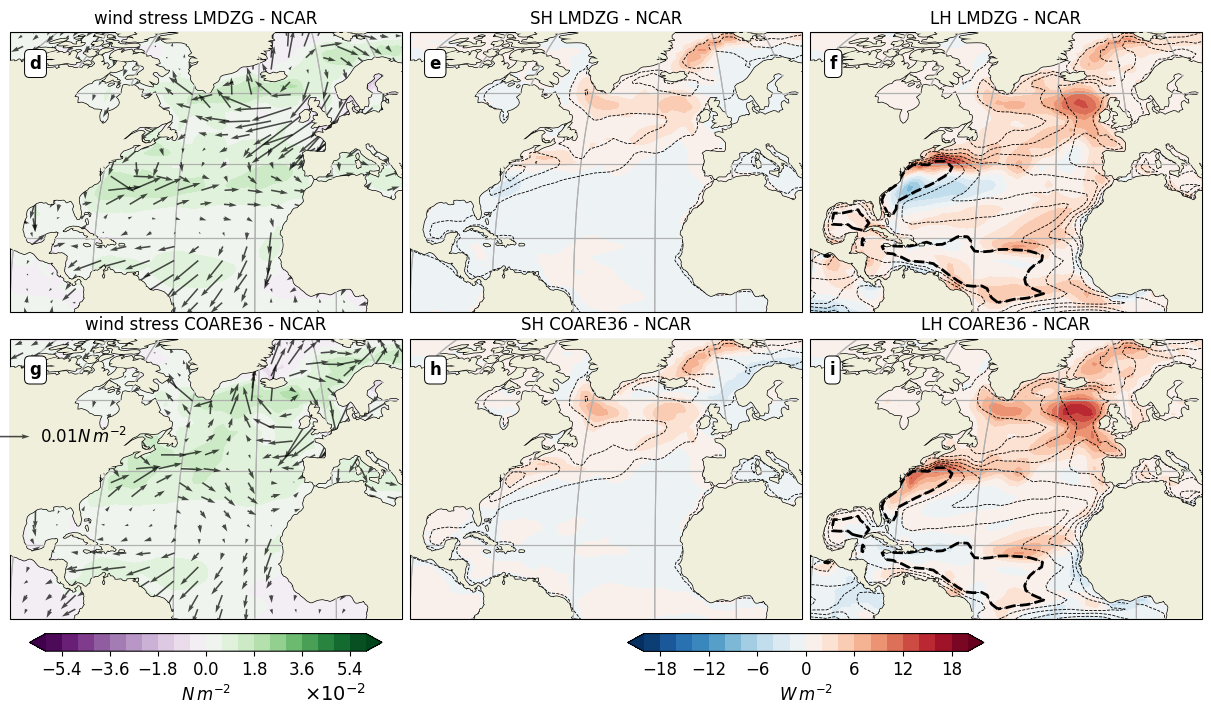

In [9]:
fig,axes = plt.subplots(2, 3, subplot_kw={'projection': ccrs.Robinson(central_longitude=-20)}, figsize=(12,7))
bulk1 = 'NCAR' ; variable ='LH'
config = 'IPSLCM71' ; realm = 'ATM'
outvar = ("tau", "SH", "LH") ; img_list = [] ; labels = ['d','e','f','g','h','i'] ; i=0
bulk_list_copy = bulk_list.copy()
bulk_list_copy.pop(bulk1)
bulk_list_copy.pop('LMDZNG') ; bulk_list_copy.pop('ECMWF')

for bulk2,axs_row in zip(bulk_list_copy,axes):
    print(bulk2)
    for flux,ax in zip(outvar,axs_row):
        
        ax.coastlines(); ax.gridlines(draw_labels=False);ax.gridlines(); ax.add_feature(cartopy.feature.LAND,zorder=10)
        ax.set_extent([-100, 20, 0, 80], crs=ccrs.PlateCarree())  ; ax.set_title(flux.replace('tau','wind stress') + ' ' + bulk2 + ' - ' + bulk1,fontsize=12)
        ax.text(0.05, 0.92, labels[i],  zorder= 12,  bbox=dict(facecolor='white', edgecolor='black',boxstyle='round,pad=0.3',linewidth=0.7),
            transform=ax.transAxes,  fontsize=12, fontweight='bold',va='top', ha='left')
        
        if flux == 'tau':
            taux = (load_data_ext(config, realm, bulk2,'taux') - load_data_ext(config, realm, bulk1,'taux')).mean(dim='month').coarsen(lon= 3, lat =3, boundary='trim').mean()
            tauy = (load_data_ext(config, realm, bulk2,'tauy') - load_data_ext(config, realm, bulk1,'tauy')).mean(dim='month').coarsen(lon= 3, lat =3, boundary='trim').mean()
            quiver = ax.quiver(taux.lon, taux.lat, taux.values, tauy.values, transform=ccrs.PlateCarree(),scale=0.1,width=4E-3,zorder=5,alpha=0.7)
            ds1 , ds2 =  load_data(config,realm,bulk1,atm_variables[flux]).mean(dim='month') , load_data(config,realm,bulk2,atm_variables[flux]).mean(dim='month')
        else:
            ds1 , ds2 =  load_data_ext(config,realm,bulk1,atm_variables[flux]).mean(dim='month') , load_data_ext(config,realm,bulk2,atm_variables[flux]).mean(dim='month')
        ds = ds2 - ds1
        lon = ds.lon ; lat = ds.lat
        ds_cyc, lon_cyc = add_cyclic_point(ds, coord=lon)

        img = ax.contourf(lon_cyc, lat, ds_cyc,  cmap=colormaps_delta_ref[flux], levels=levels_delta_ref[flux],
                          transform=ccrs.PlateCarree(),extend='both')
        if flux != 'tau':
            contour = ax.contour(lon,lat,ds1,transform=ccrs.PlateCarree(),levels=levels_short[flux], colors='k',linewidths=0.6)
            contour = ax.contour(lon, lat, ds1,transform=ccrs.PlateCarree(),levels=[levels_short[flux][np.argmax(np.abs(levels_short[flux]))]],
                        colors='k',linewidths=2)  
        img_list.append(img) 
        i += 1

# Add colorbars at the bottom of each column
cbar = fig.colorbar(img_list[0], ax=axes[-1,0], orientation='horizontal', location='bottom',shrink=0.9,pad=0.05)
cbar.set_label(r'$N\,m^{-2}$', fontsize=12)  # Add this line to set the label with units
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((-1, 2))
cbar.ax.tick_params(labelsize=12)
cbar.update_ticks()

cbar = fig.colorbar(img_list[1], ax=axes[-1,-2:], orientation='horizontal', location='bottom',shrink=0.45,pad=0.05)
cbar.set_label(r'$W\,m^{-2}$', fontsize=12)  # Add this line to set the label with units
# cbar.formatter = ScalarFormatter(useMathText=True)
# cbar.formatter.set_powerlimits((-1, 2))
cbar.ax.tick_params(labelsize=12)
cbar.update_ticks()

quiverkey = axes[1,0].quiverkey(quiver,0.05, 0.65, 0.01, r'$0.01 N\,m^{-2}$', labelpos='E',coordinates='axes',zorder = 15,fontproperties={'size':12})

# Final plot options
#-------------------------------------
title = 'Online_fluxes_differences'
plt.savefig(save_path + title + '.png')


# Fig 8 (variables diff)

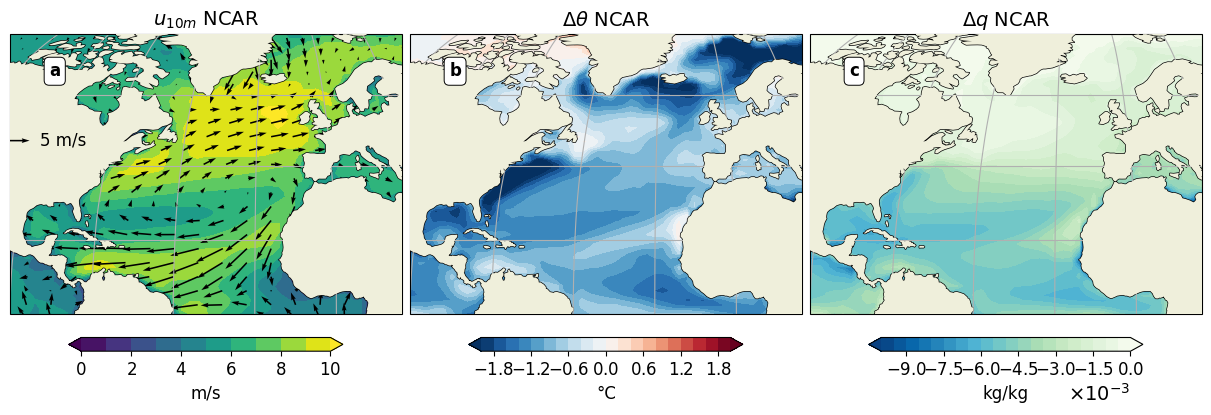

In [6]:
# Configuration and setup
fig, axes = plt.subplots(1, 3, subplot_kw={'projection': ccrs.Robinson(central_longitude=-20)}, figsize=(12, 5))
bulk1, config, realm = 'NCAR', 'IPSLCM71', 'ATM'
outvar = ("$u_{10m}$", "$\\Delta \\theta$", "$\\Delta q$")
labels = [chr(97 + i) for i in range(12)]  # 'a' to 'l'
bulk_list_copy = [bulk for bulk in bulk_list if bulk != bulk1]
levels_c = [np.arange(2, 26, 4), np.arange(-2, 0.4, 0.4), 1e-3 * np.arange(-5, 0.5, 0.5), np.arange(1, 13, 2)]

# Data loading functions
def get_delta_data_variables(flux, bulk1, bulk2):
    loaders = {
        '$\\Delta \\theta$': lambda b: (load_data_ext(config, realm, b, 't2m') - load_data_ext(config, realm, b, 'tsol')).mean(dim='month'),
        '$\\Delta q$': lambda b: (load_data_ext(config, realm, b, 'q2m') - q_sat(load_data_ext(config, realm, b, 'tsol'), load_data_ext(config, realm, b, 'slp'))).mean(dim='month'),
        '$u_{10m}$': lambda b: load_data_ext(config, realm, b, 'wind10m').mean(dim='month')}
    flux_map = {'$\\Delta \\theta$': 't2m-SST', '$\\Delta q$': 'q2m-qsurf', '$u_{10m}$': 'wind10m'}
    
    ds1 = loaders[flux](bulk1)
    return ds1, flux_map[flux]

# Setup axes
def setup_axis(ax, title, label):
    ax.coastlines() ;  ax.gridlines(draw_labels=False) ; ax.add_feature(cartopy.feature.LAND, zorder=10) ; ax.set_title(title, fontsize=14)
    ax.set_extent([-100, 20, 0, 80], crs=ccrs.PlateCarree())
    ax.text(0.1, 0.9, label, zorder=12, transform=ax.transAxes, fontsize=12, fontweight='bold',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', linewidth=0.7),
            va='top', ha='left')

# Main plotting loop
img_list = []
for j, (flux, ax) in enumerate(zip(outvar, axes)):
    setup_axis(ax, f'{flux} {bulk1}', labels[j])
    
    ds, flux_key = get_delta_data_variables(flux, bulk1, bulk1)
    ds_cyc, lon = add_cyclic_point(ds, coord=ds.lon)
    
    img = ax.contourf(lon, ds.lat, ds_cyc, cmap=colormaps_ref[flux_key], 
                        levels=levels_ref[flux_key], transform=ccrs.PlateCarree(), extend='both')
    img_list.append(img)


# Add quiver for tau
ax = axes[0]
taux = load_data_ext(config, realm, bulk1,'u10m').mean(dim='month').coarsen(lon= 3, lat =3, boundary='trim').mean()
tauy = load_data_ext(config, realm, bulk1,'v10m').mean(dim='month').coarsen(lon= 3, lat =3, boundary='trim').mean()
lon2d, lat2d = np.meshgrid(taux.lon, taux.lat)
quiver = ax.quiver(lon2d, lat2d, taux.values, tauy.values, transform=ccrs.PlateCarree(),width=4E-3,scale=100)
quiverkey = ax.quiverkey(quiver,0.05, 0.62, 5, '5 m/s', labelpos='E',
                            coordinates='axes',zorder = 11,fontproperties={'size':12})
                            
# Add colorbars
units = ['m/s','°C', 'kg/kg']
for col, unit in enumerate(units):
    cbar = fig.colorbar(img_list[col], ax=axes[col], orientation='horizontal',shrink=0.7)
    cbar.set_label(unit, fontsize=12)
    cbar.formatter = ScalarFormatter(useMathText=True)
    cbar.formatter.set_powerlimits((-1, 2))
    cbar.update_ticks()
    cbar.ax.tick_params(labelsize=12)

# Save and show
title = f"Variables {bulk1} {config}"
# plt.suptitle(title)
plt.savefig(f"{save_path}{title}.png")


LMDZG
COARE36


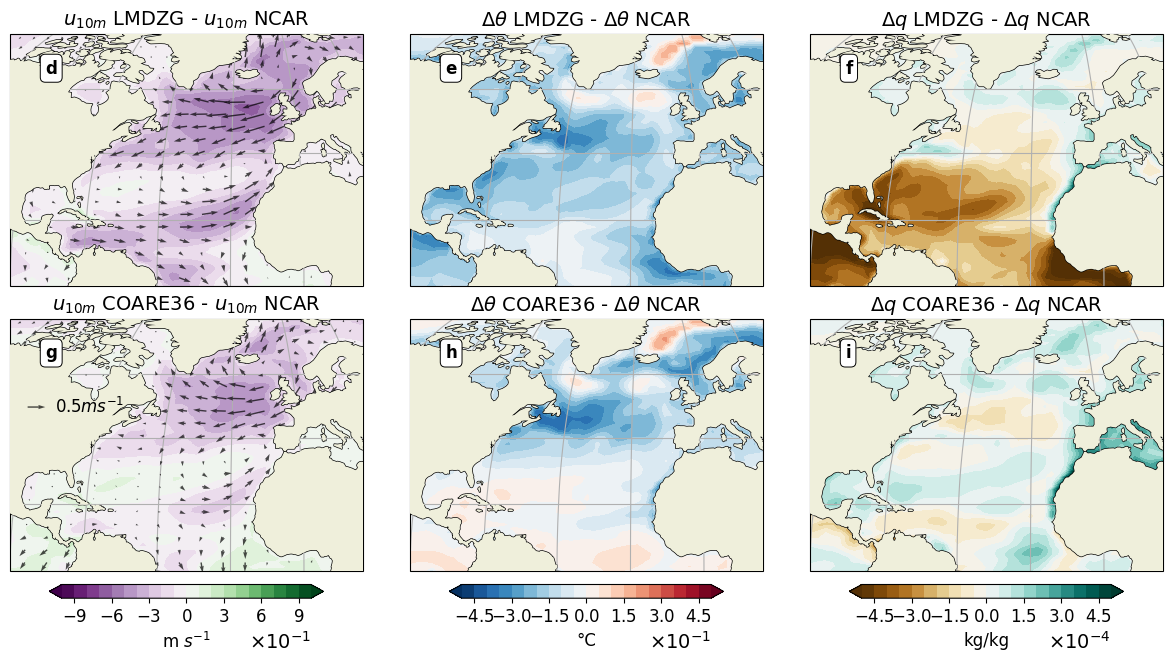

In [7]:
# Configuration and setup
fig, axes = plt.subplots(2, 3, subplot_kw={'projection': ccrs.Robinson(central_longitude=-20)}, figsize=(12, 6.5))
bulk1, config, realm = 'NCAR', 'IPSLCM71', 'ATM'
outvar = ("$u_{10m}$", "$\\Delta \\theta$", "$\\Delta q$")
labels = [chr(100 + i) for i in range(12)]  # 'a' to 'l'
bulk_list_copy = bulk_list.copy()
bulk_list_copy.pop('NCAR')  ; bulk_list_copy.pop('LMDZNG') ; bulk_list_copy.pop('ECMWF')
levels_c = [np.arange(2, 26, 4), np.arange(-2, 0.4, 0.4), 1e-3 * np.arange(-5, 0.5, 0.5), np.arange(1, 13, 2)]

# Data loading functions
def get_delta_data_variables(flux, bulk1, bulk2):
    loaders = {
        '$\\Delta \\theta$': lambda b: (load_data_ext(config, realm, b, 't2m') - load_data_ext(config, realm, b, 'tsol')).mean(dim='month'),
        '$\\Delta q$': lambda b: (load_data_ext(config, realm, b, 'q2m') - q_sat(load_data_ext(config, realm, b, 'tsol'), load_data_ext(config, realm, b, 'slp'))).mean(dim='month'),
        '$u_{10m}$': lambda b: load_data_ext(config, realm, b, 'wind10m').mean(dim='month')}
    flux_map = {'$\\Delta \\theta$': 't2m-SST', '$\\Delta q$': 'q2m', '$u_{10m}$': 'wind10m'}
    
    ds1, ds2 = loaders[flux](bulk1), loaders[flux](bulk2)
    return ds2 - ds1, flux_map[flux]

def setup_axis(ax, title, label):
    ax.coastlines() ;  ax.gridlines(draw_labels=False) ; ax.add_feature(cartopy.feature.LAND, zorder=10) ; ax.set_title(title, fontsize=14)
    ax.set_extent([-100, 20, 0, 80], crs=ccrs.PlateCarree())
    ax.text(0.1, 0.9, label, zorder=12, transform=ax.transAxes, fontsize=12, fontweight='bold',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', linewidth=0.7),
            va='top', ha='left')

# Main plotting loop
img_list = [] ; mean_value = {}
for i, (bulk2, axs_row) in enumerate(zip(bulk_list_copy, axes)):
    print(bulk2) ; mean_value = {bulk2: {}}
    for j, (flux, ax) in enumerate(zip(outvar, axs_row)):
        
        ds, flux_key = get_delta_data_variables(flux, bulk1, bulk2)
        ds_cyc, lon = add_cyclic_point(ds, coord=ds.lon)
        mean_value[bulk2][flux] = f"{ds.weighted(LMDZ_143x144_area).mean().values:.2e}"

        setup_axis(ax, f'{flux} {bulk2} - {flux} {bulk1}', labels[i*3 + j]) #({mean_value[bulk2][flux]})'

        img = ax.contourf(lon, ds.lat, ds_cyc, cmap=colormaps_delta_ref[flux_key], 
                         levels=levels_delta_ref[flux_key], transform=ccrs.PlateCarree(), extend='both')
        img_list.append(img)

        if flux  == "$u_{10m}$":
            taux = (load_data_ext(config, realm, bulk2,'u10m') - load_data_ext(config, realm, bulk1,'u10m')).mean(dim='month').coarsen(lon= 3, lat =3, boundary='trim').mean()
            tauy = (load_data_ext(config, realm, bulk2,'v10m') - load_data_ext(config, realm, bulk1,'v10m')).mean(dim='month').coarsen(lon= 3, lat =3, boundary='trim').mean()
            quiver = ax.quiver(taux.lon, taux.lat, taux.values, tauy.values, transform=ccrs.PlateCarree(),scale=10,width=4E-3,zorder=5,alpha=0.7)

# Add colorbars
units = ['m $s^{-1}$','°C', 'kg/kg']
for col, unit in enumerate(units):
    cbar = fig.colorbar(img_list[col], ax=axes[-1, col], orientation='horizontal',shrink=0.7)
    cbar.set_label(unit, fontsize=12)
    cbar.formatter = ScalarFormatter(useMathText=True)
    cbar.formatter.set_powerlimits((-1, 2))
    cbar.update_ticks()
    cbar.ax.tick_params(labelsize=12)

quiverkey = axes[1,0].quiverkey(quiver,0.1, 0.65, 0.5, '0.$5 m s^{-1}$', labelpos='E',coordinates='axes',zorder = 15,fontproperties={'size':12})

# Save and show
title = f"Variables differences {config}"
# plt.suptitle(title)
plt.savefig(f"{save_path}{title}.png")


# Fig 9 (pres. variables fluxes)

LMDZG
COARE36


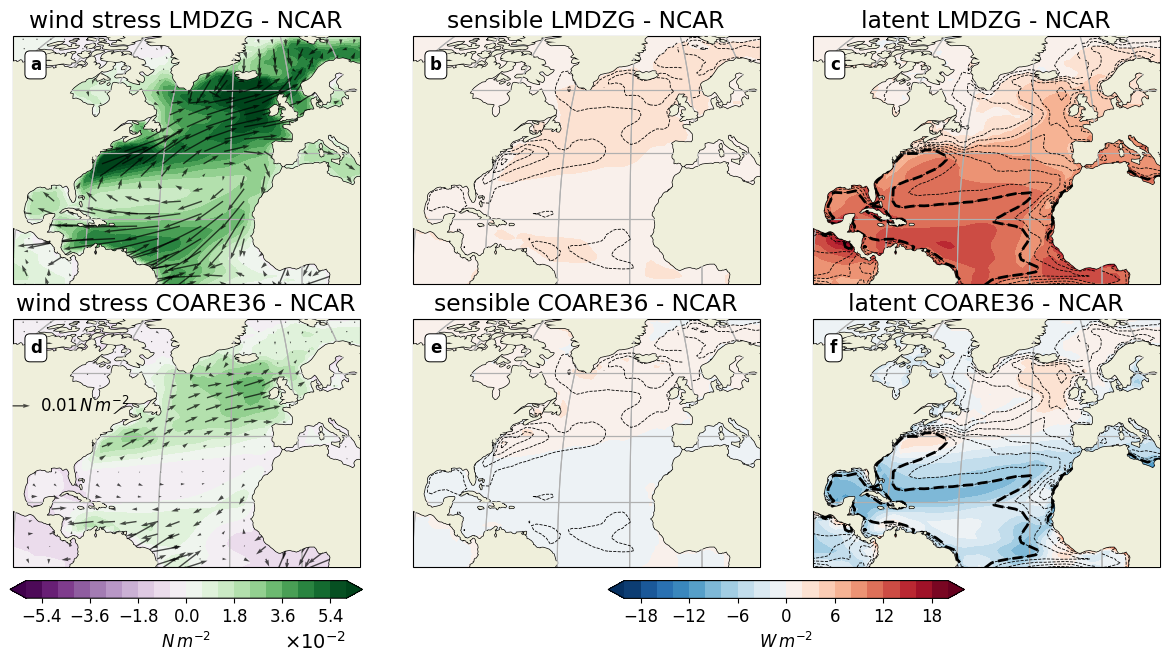

In [33]:
fig,axes = plt.subplots(2, 3, subplot_kw={'projection': ccrs.Robinson(central_longitude=-20)}, figsize=(12,6.5))#,gridspec_kw={'height_ratios': [1.3, , 1, 1.3]})
bulk1 = 'NCAR' ; config = 'IPSLCM71' ; realm = 'ATM'
labels = ['a','b','c','d','e','f','g','h','i'] ; i = 0 
img_list = [] ; outvar = ("tau", "sensible", "latent")

lat = OCE_MASK_143x144.lat ; lon = OCE_MASK_143x144.lon
(Nt,Ni,Nj) = np.shape(OCE_MASK_143x144)

kwargs = dict(
    hin=np.array([10*np.ones(Nt*Ni*Nj),2*np.ones(Nt*Ni*Nj),2*np.ones(Nt*Ni*Nj)]),
    hout=10,wl=0,cskin=0,Rl=0, Rs=0, L='Rb')

# Load the run outputs from one run
#---------------------------
wind10m =  load_data_ext(config,realm,bulk1,'wind10m')
u10m =  load_data_ext(config,realm,bulk1,'u10m')
v10m =  load_data_ext(config,realm,bulk1,'v10m')
u_factor = u10m / wind10m
v_factor = v10m / wind10m
gusts = load_data_ext(config,realm,bulk1,'gusts')**0.5
t2m = load_data_ext(config,realm,bulk1,'t2m')
tsol = load_data_ext(config,realm,bulk1,'tsol')
q2m = load_data_ext(config,realm,bulk1,'q2m')
msl = load_data_ext(config,realm,bulk1,'slp')
qsurf = q_sat(tsol, msl)

wind10m = wind10m.values.flatten() ; t2m = t2m.values.flatten() ; tsol = tsol.values.flatten() ; q2m = q2m.values.flatten() ; qsurf = qsurf.values.flatten() ; gusts = gusts.values.flatten()

# Compute the reference fluxes
# ---------------------------s
offline_v1_b1 = AirSeaFluxCode.AirSeaFluxCode(spd=wind10m, T=t2m, SST=tsol, hum=['q', 1e3 * q2m],
         meth=airseafluxes_bulk[bulk1],SST_fl=SST_fl_dict[bulk1], gust=0, **kwargs)
    
# What really happens in LMDZ (following beljaars_parametrization_1995)
offline_v1_b1['ce'] =  offline_v1_b1['ct'] * ((np.log(zu / offline_v1_b1['zot']) - offline_v1_b1['psit'] )/ (np.log(zu / (offline_v1_b1['zot'] * f_z0qh_oce)) -  offline_v1_b1['psit'] ) )
offline_v1_b1['tau'] =  offline_v1_b1['cd'] * rho_air * (wind10m+gusts) * (wind10m+gusts)
offline_v1_b1['sensible'] =  offline_v1_b1['ct'] * rho_air * (wind10m+gusts) * Cp_air * (offline_v1_b1['tref'] - tsol)
offline_v1_b1['latent'] =  offline_v1_b1['ce'] * rho_air * (wind10m+gusts) * Lv * (offline_v1_b1['qref']/1e3 - qsurf*f_qsat_oce[bulk1]) 

ds_ref = dict()
for flux in ["tau", "sensible", "latent"]:
    ds_ref[flux] = np.reshape(np.array(offline_v1_b1[flux]), (Nt, Ni, Nj)).mean(axis=0)
    ds_ref[flux] = xr.DataArray(ds_ref[flux], coords={'lat': lat, 'lon': lon}, dims=["lat", "lon"])

bulk_list_copy = bulk_list.copy()
bulk_list_copy.pop(bulk1)
bulk_list_copy.pop('LMDZNG')
bulk_list_copy.pop('ECMWF')
img_list = []

for bulk2,axs_row in zip(bulk_list_copy,axes):

    print(bulk2)
    if 'LMDZ' in bulk2:                
        offline_v1_b2 = dict()
        if 'LMDZG' in bulk2:
            Cd, Ch, Ce, zCdN, zChN, zCeN, FM, FH, zri, tau, SH, LH, q_zu, t_zu = turb_lmdzng(sst=tsol, t_zt=t2m, ssq=qsurf, q_zt=q2m, U_zu=wind10m,nb_iter=3,gusts=True)
            offline_v1_b2['latent'] = Ce * rho_air * (wind10m+gusts) * Lv * (q_zu - qsurf*f_qsat_oce[bulk2]) 
            offline_v1_b2['sensible'] = Ch * rho_air *  (wind10m+gusts) * Cp_air * (t_zu - tsol)
        elif 'LMDZNG' in bulk2:
            Cd, Ch, Ce, zCdN, zChN, zCeN, FM, FH, zri, tau, SH, LH, q_zu, t_zu = turb_lmdzng(sst=tsol, t_zt=t2m, ssq=qsurf, q_zt=q2m, U_zu=wind10m,nb_iter=3,gusts=False)
            offline_v1_b2['latent'] = Ce * rho_air * (wind10m) * Lv * (q_zu - qsurf*f_qsat_oce[bulk2]) 
            offline_v1_b2['sensible'] = Ch * rho_air *  (wind10m) * Cp_air * (t_zu - tsol)
        offline_v1_b2['tau'] = Cd * rho_air *  (wind10m+gusts) * (wind10m+gusts)
    else:
        offline_v1_b2 = AirSeaFluxCode.AirSeaFluxCode(spd=wind10m, T=t2m, SST=tsol, hum=['q', 1e3 * q2m],
            meth=airseafluxes_bulk[bulk2],SST_fl=SST_fl_dict[bulk2],
            gust = [1, 1.2, 600, 0.5] if bulk2 == 'COARE36' else [4, 1, 1000, 0.01], **kwargs)
            
        # What really happens in LMDZ (following beljaars_parametrization_1995)
        offline_v1_b2['ce'] =  offline_v1_b2['ct'] * ((np.log(zu / offline_v1_b2['zot']) - offline_v1_b2['psit'] ) / (np.log(zu / (offline_v1_b2['zot'] * f_z0qh_oce)) -  offline_v1_b2['psit'] ) )
        offline_v1_b2['tau'] =  offline_v1_b2['cd'] * rho_air * (wind10m+gusts) * (wind10m+gusts) 
        offline_v1_b2['sensible'] =  offline_v1_b2['ct'] * rho_air * (wind10m+gusts) * Cp_air * (offline_v1_b1['tref'] - tsol)
        offline_v1_b2['latent'] =  offline_v1_b2['ce'] * rho_air * (wind10m+gusts) * Lv * (offline_v1_b1['qref']/1e3 - qsurf*f_qsat_oce[bulk2])


    delta_bulk = dict()
    for flux,ax in zip(outvar,axs_row):

        ax.coastlines(); ax.gridlines(draw_labels=False);ax.gridlines(); ax.add_feature(cartopy.feature.LAND,zorder=10)
        ax.set_extent([-100, 20, 0, 80], crs=ccrs.PlateCarree()) ; ax.set_title(flux.replace('tau','wind stress') + ' ' + bulk2 + ' - ' + bulk1)
        ax.text(0.05, 0.92, labels[i],  zorder= 12,  bbox=dict(facecolor='white', edgecolor='black',boxstyle='round,pad=0.3',linewidth=0.7),
                    transform=ax.transAxes,  fontsize=12, fontweight='bold',va='top', ha='left')
        
        delta_bulk[flux] = np.reshape(np.array(offline_v1_b2[flux]) - np.array(offline_v1_b1[flux]), (Nt, Ni, Nj)).mean(axis=0)
        delta_bulk[flux] = xr.DataArray(delta_bulk[flux], coords={'lat': lat, 'lon': lon}, dims=["lat", "lon"])

        ds =  delta_bulk[flux]
        ds_cyc, lon_cyc = add_cyclic_point(ds, coord=lon)

        if flux=='tau':
            taux = (delta_bulk[flux] * u_factor).mean(dim='month').coarsen(lon= 3, lat =3, boundary='trim').mean()
            tauy = (delta_bulk[flux] * v_factor).mean(dim='month').coarsen(lon= 3, lat =3, boundary='trim').mean()
            quiver = ax.quiver(taux.lon, taux.lat, taux.values, tauy.values, transform=ccrs.PlateCarree(),scale=0.2,width=4E-3,zorder=5,alpha=0.7)
        else:
            contour = ax.contour(lon,lat,ds_ref[flux],transform=ccrs.PlateCarree(),levels=levels_short[flux], colors='k',linewidths=0.6)
            contour = ax.contour(lon, lat,ds_ref[flux],transform=ccrs.PlateCarree(),levels=[levels_short[flux][np.argmax(np.abs(levels_short[flux]))]],
                        colors='k',linewidths=2)  

        if flux=='sensible':
            flux = 'SH'
        if flux=='latent':
            flux = 'LH'
        img = ax.contourf(lon_cyc, lat, ds_cyc,  cmap=colormaps_delta_ref[flux], levels=levels_delta_ref[flux],
                            transform=ccrs.PlateCarree(),extend='both')
        img_list.append(img) ; i += 1

cbar = fig.colorbar(img_list[0], ax=axes[-1,0], orientation='horizontal', location='bottom',shrink=0.9,pad=0.05)
cbar.set_label(r'$N\,m^{-2}$', fontsize=12)  # Add this line to set the label with units
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((-1, 2))
cbar.ax.tick_params(labelsize=12)
cbar.update_ticks()

cbar = fig.colorbar(img_list[1], ax=axes[-1,-2:], orientation='horizontal', location='bottom',shrink=0.45,pad=0.05)
cbar.set_label(r'$W\,m^{-2}$', fontsize=12)  # Add this line to set the label with units
# cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((-1, 2))
cbar.ax.tick_params(labelsize=12)
cbar.update_ticks()
quiverkey = axes[1,0].quiverkey(quiver,0.05, 0.65, 0.01, r'$0.01\, N\,m^{-2}$', labelpos='E',coordinates='axes',zorder = 15,fontproperties={'size':12})


# Final plot options
#-------------------------------------
title = 'Offline_fluxes_differences'
plt.savefig(save_path + title + '.png')
plt.show()

# Fig 10 (heat fluxes decompos)

## Offline decomposition

In [8]:
bulk1 = 'NCAR' ; config = 'IPSLCM71' ; realm = 'ATM'
outvar = ("tau", "sensible", "latent")
lat = OCE_MASK_143x144.lat ; lon = OCE_MASK_143x144.lon
(Nt,Ni,Nj) = np.shape(OCE_MASK_143x144)

kwargs = dict(
    hin=np.array([10*np.ones(Nt*Ni*Nj),2*np.ones(Nt*Ni*Nj),2*np.ones(Nt*Ni*Nj)]),
    hout=10,wl=0,cskin=0,Rl=0, Rs=0, L='Rb')


# Load the run outputs from bulk
#---------------------------
wind10m_1 = load_data_ext(config,realm,bulk1,'wind10m').values.flatten()
t2m_1 = load_data_ext(config,realm,bulk1,'t2m').values.flatten()
tsol_1 = load_data_ext(config,realm,bulk1,'tsol').values.flatten()
q2m_1 = load_data_ext(config,realm,bulk1,'q2m').values.flatten()
qsurf_1 = q_sat(tsol_1, load_data_ext(config,realm,bulk1,'slp').values.flatten())
gusts_1 =  0#load_data_ext(config,realm,bulk1,'gusts').values.flatten() ** 0.5

offline_v1 = {} 
for bulk2 in bulk_list:
    if 'LMDZ' not in bulk2:
        offline_v1_b2 = AirSeaFluxCode.AirSeaFluxCode(spd=wind10m_1,T=t2m_1,SST=tsol_1, hum=['q', 1e3 * q2m_1], meth=airseafluxes_bulk[bulk2],SST_fl=SST_fl_dict[bulk2], **kwargs)
        # What really happens in LMDZ (following beljaars_parametrization_1995)
        offline_v1_b2['ce'] =  offline_v1_b2['ct'] * ((np.log(zu / offline_v1_b2['zot']) - offline_v1_b2['psit'] ) / (np.log(zu / (offline_v1_b2['zot'] * f_z0qh_oce)) -  offline_v1_b2['psit'] ) )
        offline_v1_b2['tau'] =  offline_v1_b2['cd'] * rho_air * (wind10m_1+gusts_1) * (wind10m_1+gusts_1) 
        offline_v1_b2['sensible'] =  offline_v1_b2['ct'] * rho_air * (wind10m_1+gusts_1) * Cp_air * (offline_v1_b2['tref'] - tsol_1)
        offline_v1_b2['latent'] =  offline_v1_b2['ce'] * rho_air * (wind10m_1+gusts_1) * Lv * (offline_v1_b2['qref']/1e3 - qsurf_1*f_qsat_oce[bulk2])
    else:
        offline_v1_b2 = dict()
        if 'LMDZG' in bulk2:
            Cd, Ch, Ce, zCdN, zChN, zCeN, FM, FH, zri, tau, SH, LH, q_zu, t_zu = turb_lmdzng(sst=tsol_1, t_zt=t2m_1, ssq=qsurf_1, q_zt=q2m_1, U_zu=wind10m_1, nb_iter=3,gusts=True)
            offline_v1_b2['latent'] = Ce * rho_air * (wind10m_1+gusts_1) * Lv * (q_zu - qsurf_1*f_qsat_oce[bulk2]) 
            offline_v1_b2['sensible'] = Ch * rho_air *  (wind10m_1+gusts_1) * Cp_air * (t_zu - tsol_1)
        elif 'LMDZNG' in bulk2:
            Cd, Ch, Ce, zCdN, zChN, zCeN, FM, FH, zri, tau, SH, LH, q_zu, t_zu = turb_lmdzng(sst=tsol_1, t_zt=t2m_1, ssq=qsurf_1, q_zt=q2m_1, U_zu=wind10m_1, nb_iter=3,gusts=False)
            offline_v1_b2['latent'] = Ce * rho_air * (wind10m_1+gusts_1) * Lv * (q_zu - qsurf_1*f_qsat_oce[bulk2]) 
            offline_v1_b2['sensible'] = Ch * rho_air *  (wind10m_1+gusts_1) * Cp_air * (t_zu - tsol_1)
        offline_v1_b2['tau'] = Cd * rho_air *  (wind10m_1+gusts_1) * (wind10m_1+gusts_1)


    offline_v1[bulk2] = dict()
    for flux in outvar:
        offline_v1[bulk2][flux] = np.reshape(np.array(offline_v1_b2[flux]), (Nt, Ni, Nj))
        offline_v1[bulk2][flux] = xr.DataArray(offline_v1[bulk2][flux], coords={'month': np.arange(1,13), 'lat': lat, 'lon': lon}, dims=["month", "lat", "lon"])


In [ ]:

for bulk in bulk_list:
    online = load_data(config,realm,bulk,'taum').where(OCE_MASK_143x144)
    print(xr.corr(offline_v2[bulk]['tau'],online).values)

0.6826291765228519
0.7047110039910119
0.7059312626597406
0.7228503047726885
0.7107702637905539


In [ ]:

for bulk in bulk_list:
    online = load_data(config,realm,bulk,'flat').where(OCE_MASK_143x144)
    print(xr.corr(offline_v2[bulk]['latent'],online).values)

0.8625651565334791
0.8292820822948059
0.8518798075845676
0.8652173094023049
0.863480730375691


In [ ]:

for bulk in bulk_list:
    online = load_data(config,realm,bulk,'sens').where(OCE_MASK_143x144)
    print(xr.corr(offline_v1[bulk]['sensible'],online).values)

0.8071204562324414
0.8140770067041606
0.7949693852244346
0.797937429040884
0.8010290263205153


In [9]:
bulk1 = 'NCAR' ; config = 'IPSLCM71' ; realm = 'ATM'
outvar = ("tau", "sensible", "latent")
lat = OCE_MASK_143x144.lat ; lon = OCE_MASK_143x144.lon
(Nt,Ni,Nj) = np.shape(OCE_MASK_143x144)

kwargs = dict(
    hin=np.array([10*np.ones(Nt*Ni*Nj),2*np.ones(Nt*Ni*Nj),2*np.ones(Nt*Ni*Nj)]),
    hout=10,wl=0,cskin=0,Rl=0, Rs=0, L='Rb')

# wind10m_2 = load_data_ext(config,realm,bulk2,'wind10m').values.flatten()
# gusts_2 =  load_data_ext(config,realm,bulk2,'gusts').values.flatten() ** 0.5
t2m_2 = load_data_ext(config,realm,bulk1,'t2m').values.flatten()
q2m_2 = load_data_ext(config,realm,bulk1,'q2m').values.flatten()
tsol_2 = load_data_ext(config,realm,bulk1,'tsol').values.flatten()
qsurf_2 = q_sat(tsol_2, load_data_ext(config,realm,bulk1,'slp').values.flatten())

offline_wind = {}
bulk_list_copy = bulk_list.copy() ; bulk_list_copy.pop('LMDZNG'); bulk_list_copy.pop('ECMWF')
for bulk2 in bulk_list_copy:
    # Load the run outputs from bulk
    #---------------------------
    wind10m_2 = load_data_ext(config,realm,bulk2,'wind10m').values.flatten()
    gusts_2 = 0# load_data_ext(config,realm,bulk2,'gusts').values.flatten() ** 0.5

    if 'LMDZ' not in bulk2:
        offline_v2_b2 = AirSeaFluxCode.AirSeaFluxCode(spd=wind10m_2, T=t2m_2,SST=tsol_2, hum=['q', 1e3 * q2m_2], meth=airseafluxes_bulk[bulk2],SST_fl=SST_fl_dict[bulk2], **kwargs)
        # What really happens in LMDZ (following beljaars_parametrization_1995)
        offline_v2_b2['ce'] =  offline_v2_b2['ct'] * ((np.log(zu / offline_v2_b2['zot']) - offline_v2_b2['psit'] )/ (np.log(zu / (offline_v2_b2['zot'] * f_z0qh_oce)) -  offline_v2_b2['psit'] ) )
        offline_v2_b2['tau'] =  offline_v2_b2['cd'] * rho_air * (wind10m_2+gusts_2) * (wind10m_2+gusts_2)
        offline_v2_b2['sensible'] =  offline_v2_b2['ct'] * rho_air * (wind10m_2+gusts_2) * Cp_air * (offline_v2_b2['tref'] - tsol_2)
        offline_v2_b2['latent'] =  offline_v2_b2['ce'] * rho_air * (wind10m_2+gusts_2) * Lv * (offline_v2_b2['qref']/1e3 - qsurf_2*f_qsat_oce[bulk2]) 
    else:
        offline_v2_b2 = dict()
        if 'LMDZG' in bulk2:
            Cd, Ch, Ce, zCdN, zChN, zCeN, FM, FH, zri, tau, SH, LH, q_zu, t_zu = turb_lmdzng(sst=tsol_2, t_zt=t2m_2, ssq=qsurf_2, q_zt=q2m_2, U_zu=wind10m_2,nb_iter=3,gusts=True)
            offline_v2_b2['latent'] = Ce * rho_air * (wind10m_2+gusts_2) * Lv * (q_zu - qsurf_2*f_qsat_oce[bulk2]) 
            offline_v2_b2['sensible'] = Ch * rho_air *  (wind10m_2+gusts_2) * Cp_air * (t_zu - tsol_2)
        elif 'LMDZNG' in bulk2:
            Cd, Ch, Ce, zCdN, zChN, zCeN, FM, FH, zri, tau, SH, LH, q_zu, t_zu = turb_lmdzng(sst=tsol_2, t_zt=t2m_2, ssq=qsurf_2, q_zt=q2m_2, U_zu=wind10m_2,nb_iter=3,gusts=False)
            offline_v2_b2['latent'] = Ce * rho_air * (wind10m_2+gusts_2) * Lv * (q_zu - qsurf_2*f_qsat_oce[bulk2]) 
            offline_v2_b2['sensible'] = Ch * rho_air *  (wind10m_2+gusts_2) * Cp_air * (t_zu - tsol_2)
        offline_v2_b2['tau'] = Cd * rho_air *  (wind10m_2+gusts_2) * (wind10m_2+gusts_2)


    offline_wind[bulk2] = dict()
    for flux in outvar:
        offline_wind[bulk2][flux] = np.reshape(np.array(offline_v2_b2[flux]), (Nt, Ni, Nj))
        offline_wind[bulk2][flux] = xr.DataArray(offline_wind[bulk2][flux], coords={'month': np.arange(1,13), 'lat': lat, 'lon': lon}, dims=["month", "lat", "lon"])


In [10]:
bulk1 = 'NCAR' ; config = 'IPSLCM71' ; realm = 'ATM'
outvar = ("tau", "sensible", "latent")
lat = OCE_MASK_143x144.lat ; lon = OCE_MASK_143x144.lon
(Nt,Ni,Nj) = np.shape(OCE_MASK_143x144)

kwargs = dict(
    hin=np.array([10*np.ones(Nt*Ni*Nj),2*np.ones(Nt*Ni*Nj),2*np.ones(Nt*Ni*Nj)]),
    hout=10,wl=0,cskin=0,Rl=0, Rs=0, L='Rb')

wind10m_2 = load_data_ext(config,realm,bulk1,'wind10m').values.flatten()
gusts_2 =  0#load_data_ext(config,realm,bulk1,'gusts').values.flatten() ** 0.5
# t2m_2 = load_data_ext(config,realm,bulk1,'t2m').values.flatten()
# q2m_2 = load_data_ext(config,realm,bulk1,'q2m').values.flatten()
# tsol_2 = load_data_ext(config,realm,bulk1,'tsol').values.flatten()
# qsurf_2 = q_sat(tsol_2, load_data_ext(config,realm,bulk1,'slp').values.flatten())

offline_sst_t2m_q2m = {} 
bulk_list_copy = bulk_list.copy() ; bulk_list_copy.pop('LMDZNG'); bulk_list_copy.pop('ECMWF')
for bulk2 in bulk_list_copy:
    # Load the run outputs from bulk
    #---------------------------
    t2m_2 = load_data_ext(config,realm,bulk2,'t2m').values.flatten()
    q2m_2 = load_data_ext(config,realm,bulk2,'q2m').values.flatten()
    tsol_2 = load_data_ext(config,realm,bulk2,'tsol').values.flatten()
    qsurf_2 = q_sat(tsol_2, load_data_ext(config,realm,bulk2,'slp').values.flatten())
    
    if 'LMDZ' not in bulk2:
        offline_v2_b2 = AirSeaFluxCode.AirSeaFluxCode(spd=wind10m_2, T=t2m_2,SST=tsol_2, hum=['q', 1e3 * q2m_2], meth=airseafluxes_bulk[bulk2],SST_fl=SST_fl_dict[bulk2], **kwargs)
        # What really happens in LMDZ (following beljaars_parametrization_1995)
        offline_v2_b2['ce'] =  offline_v2_b2['ct'] * ((np.log(zu / offline_v2_b2['zot']) - offline_v2_b2['psit'] )/ (np.log(zu / (offline_v2_b2['zot'] * f_z0qh_oce)) -  offline_v2_b2['psit'] ) )
        offline_v2_b2['tau'] =  offline_v2_b2['cd'] * rho_air * (wind10m_2+gusts_2) * (wind10m_2+gusts_2)
        offline_v2_b2['sensible'] =  offline_v2_b2['ct'] * rho_air * (wind10m_2+gusts_2) * Cp_air * (offline_v2_b2['tref'] - tsol_2)
        offline_v2_b2['latent'] =  offline_v2_b2['ce'] * rho_air * (wind10m_2+gusts_2) * Lv * (offline_v2_b2['qref']/1e3 - qsurf_2*f_qsat_oce[bulk2]) 
    else:
        offline_v2_b2 = dict()
        if 'LMDZG' in bulk2:
            Cd, Ch, Ce, zCdN, zChN, zCeN, FM, FH, zri, tau, SH, LH, q_zu, t_zu = turb_lmdzng(sst=tsol_2, t_zt=t2m_2, ssq=qsurf_2, q_zt=q2m_2, U_zu=wind10m_2,nb_iter=3,gusts=True)
            offline_v2_b2['latent'] = Ce * rho_air * (wind10m_2+gusts_2) * Lv * (q_zu - qsurf_2*f_qsat_oce[bulk2]) 
            offline_v2_b2['sensible'] = Ch * rho_air *  (wind10m_2+gusts_2) * Cp_air * (t_zu - tsol_2)
        elif 'LMDZNG' in bulk2:
            Cd, Ch, Ce, zCdN, zChN, zCeN, FM, FH, zri, tau, SH, LH, q_zu, t_zu = turb_lmdzng(sst=tsol_2, t_zt=t2m_2, ssq=qsurf_2, q_zt=q2m_2, U_zu=wind10m_2,nb_iter=3,gusts=False)
            offline_v2_b2['latent'] = Ce * rho_air * (wind10m_2+gusts_2) * Lv * (q_zu - qsurf_2*f_qsat_oce[bulk2]) 
            offline_v2_b2['sensible'] = Ch * rho_air *  (wind10m_2+gusts_2) * Cp_air * (t_zu - tsol_2)
        offline_v2_b2['tau'] = Cd * rho_air *  (wind10m_2+gusts_2) * (wind10m_2+gusts_2)


    offline_sst_t2m_q2m[bulk2] = dict()
    for flux in outvar:
        offline_sst_t2m_q2m[bulk2][flux] = np.reshape(np.array(offline_v2_b2[flux]), (Nt, Ni, Nj))
        offline_sst_t2m_q2m[bulk2][flux] = xr.DataArray(offline_sst_t2m_q2m[bulk2][flux], coords={'month': np.arange(1,13), 'lat': lat, 'lon': lon}, dims=["month", "lat", "lon"])


## Figure

LMDZG
COARE36


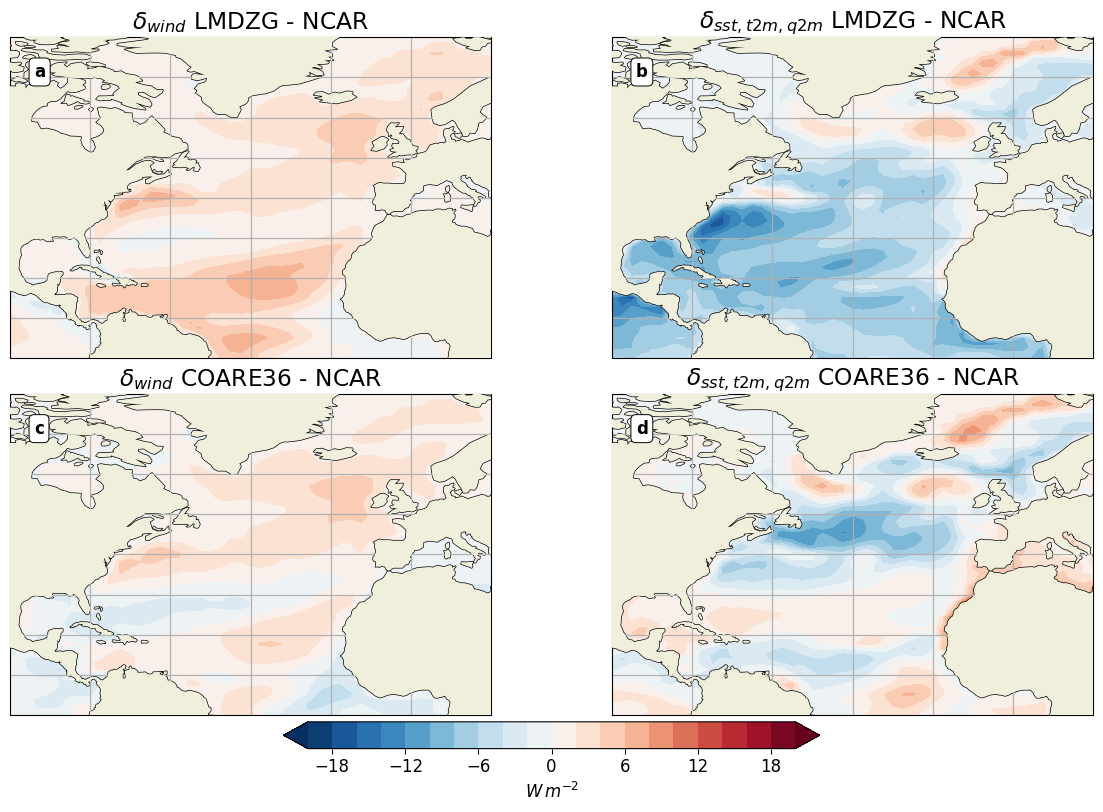

In [11]:
fig,axes = plt.subplots(2, 2, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-20)}, figsize=(12,8))#,gridspec_kw={'height_ratios': [1.3, , 1, 1.3]})
bulk1 = 'NCAR' ; config = 'IPSLCM71' ; realm = 'ATM'
labels = ['a','b','c','d','e','f','g','h','i'] ; i = 0 
img_list = [] ; outvar = ("tau", "sensible", "latent")

lat = OCE_MASK_143x144.lat ; lon = OCE_MASK_143x144.lon
(Nt,Ni,Nj) = np.shape(OCE_MASK_143x144)

bulk_list_copy = bulk_list.copy()
bulk_list_copy.pop(bulk1)
bulk_list_copy.pop('LMDZNG')
bulk_list_copy.pop('ECMWF')
img_list = []

for bulk2,axs_row in zip(bulk_list_copy,axes):
    print(bulk2)
    delta_wind = (offline_wind[bulk2]['latent'] - offline_v1[bulk2]['latent'] + offline_wind[bulk2]['sensible'] - offline_v1[bulk2]['sensible'] ).mean('month')
    delta_sst_t2m_q2m = (offline_sst_t2m_q2m[bulk2]['latent'] - offline_v1[bulk2]['latent'] + offline_sst_t2m_q2m[bulk2]['sensible'] - offline_v1[bulk2]['sensible'] ) .mean('month')
    # delta_sst = (offline_sst[bulk2]['latent'] - offline_v1[bulk2]['latent']+offline_sst[bulk2]['sensible'] - offline_v1[bulk2]['sensible'] ) .mean('month')

    for ax,ds,title in zip(axs_row,[delta_wind,delta_sst_t2m_q2m],['$\\delta_{wind}$','$\\delta_{sst,t2m,q2m}$']):
        ax.coastlines(); ax.gridlines(draw_labels=False);ax.gridlines(); ax.add_feature(cartopy.feature.LAND,zorder=10)
        ax.set_extent([-100, 20, 0, 80], crs=ccrs.PlateCarree()) ; ax.set_title(title + ' ' + bulk2 + ' - ' + bulk1)
        ax.text(0.05, 0.92, labels[i],  zorder= 12,  bbox=dict(facecolor='white', edgecolor='black',boxstyle='round,pad=0.3',linewidth=0.7),
                    transform=ax.transAxes,  fontsize=12, fontweight='bold',va='top', ha='left')
        
        ds_cyc, lon_cyc = add_cyclic_point(ds, coord=lon)
        img = ax.contourf(lon_cyc, lat, ds_cyc,  cmap='RdBu_r', levels=np.linspace(-1,1,21)*20,
                            transform=ccrs.PlateCarree(),extend='both')
        img_list.append(img) ; i += 1

cbar = fig.colorbar(img_list[1], ax=axes[-1,:], orientation='horizontal', location='bottom',shrink=0.45,pad=0.02)
cbar.set_label(r'$W\,m^{-2}$', fontsize=12)  # Add this line to set the label with units
cbar.ax.tick_params(labelsize=12)


# Final plot options
#-------------------------------------
title = 'Decompo_Offline_differences'
plt.savefig(save_path + title + '.png')

# Fig 11 (curl and gyres end)

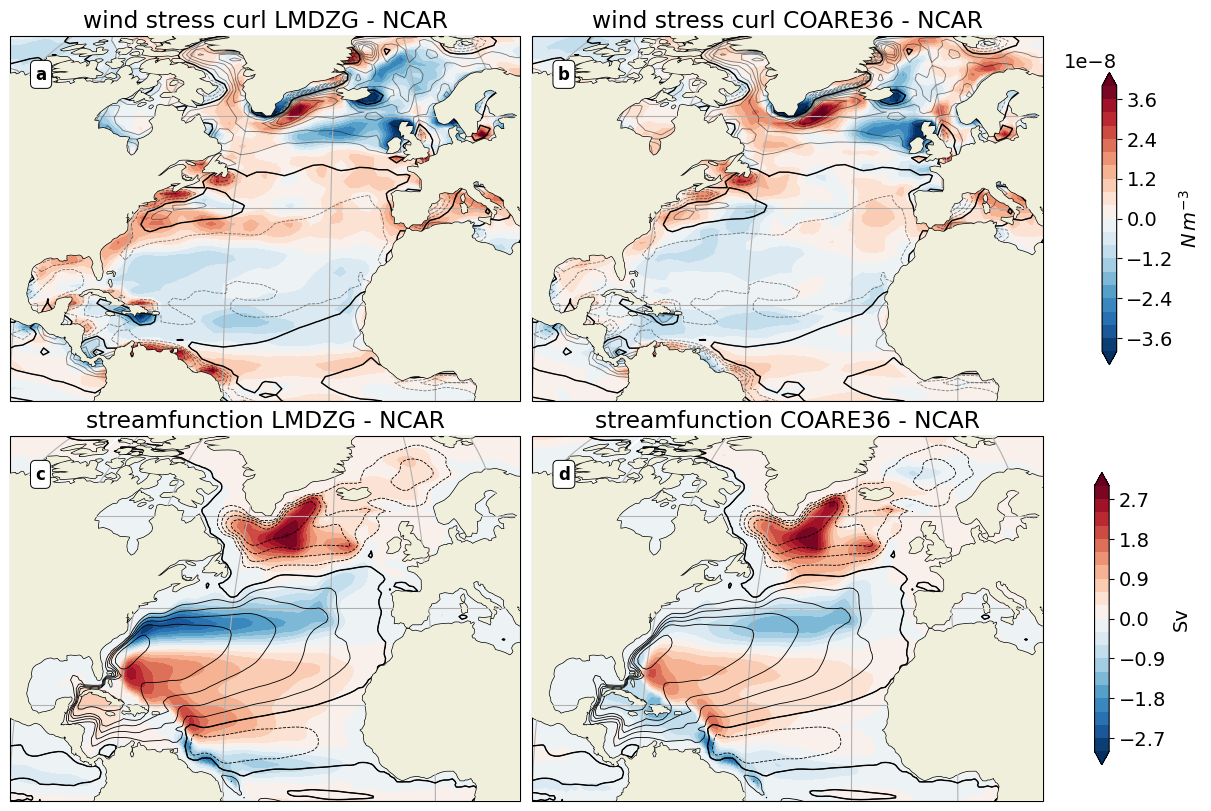

In [10]:
config = 'IPSLCM71';realm = 'ATM';bulk_ref = 'NCAR'; i=0

fig,axs = plt.subplots(2, 2, subplot_kw={'projection': ccrs.Robinson(central_longitude=-20)}, figsize=(12,8))
levels = np.linspace(-1,1,21) *2e2 ; cmap= 'RdBu_r'
scale = 2 ; labels = ['a','b','c','d'] ; i=0

ux = load_data_ext(config, 'OCE', bulk_ref, 'uo', 'T', 'U').rename({'depth':'z'})
psi_ref = nemo.bsf(ux,ORCA1_cfg.e2u*ORCA1_cfg.e3u_0,mask= ORCA1_weights>0,nperio=0, bsf0={'x':5, 'y':300} ).mean('month').isel(t=0) / 1e6

u_ref = load_data_ext('IPSLCM71',realm, bulk_ref, 'taux').mean('month')
v_ref = load_data_ext('IPSLCM71',realm, bulk_ref, 'tauy').mean('month')
w = windspharm.xarray.VectorWind(u_ref, v_ref)
curl_ref = w.vorticity().rolling(lon=scale, lat=scale, center=True, min_periods=1).mean()
curl_ref, lon_cyc = add_cyclic_point(curl_ref, coord=curl_ref.lon)

for ax in (axs.flatten()):
    ax.coastlines(); ax.gridlines(draw_labels=False); ax.add_feature(cartopy.feature.LAND,zorder=10)
    ax.set_extent([-100, 20, 0, 80], crs=ccrs.PlateCarree())
    ax.text(0.05, 0.92, labels[i],  zorder= 12,  bbox=dict(facecolor='white', edgecolor='black',boxstyle='round,pad=0.3',linewidth=0.7),
     transform=ax.transAxes,  fontsize=12, fontweight='bold',va='top', ha='left')
    i +=1

for ax_cols,bulk in zip(axs.T,['LMDZG','COARE36']):

    # Curl of wind stress
    # ======================
    ax = ax_cols[0] ; ax.set_title('wind stress curl ' + bulk + ' - ' + bulk_ref)
    u = load_data_ext('IPSLCM71',realm, bulk, 'taux').mean('month')
    v = load_data_ext('IPSLCM71',realm, bulk, 'tauy').mean('month')
    w = windspharm.xarray.VectorWind(u, v)
    curl = w.vorticity().rolling(lon=scale, lat=scale, center=True, min_periods=1).mean()
    curl, lon_cyc = add_cyclic_point(curl, coord=curl.lon)

    img_curl = ax.contourf(lon_cyc,u.lat,np.flip(curl-curl_ref,axis=0),transform=ccrs.PlateCarree(),
                levels=np.linspace(-1,1,21) *4e-8,cmap= 'RdBu_r',extend='both')
    contour = ax.contour(lon_cyc,u.lat,np.flip(curl_ref,axis=0),transform=ccrs.PlateCarree(),
                levels=np.linspace(-1,1,11) *4e-7,colors= 'k',alpha=0.5,linewidths=0.6)
    contour0 = ax.contour(lon_cyc,u.lat,np.flip(curl_ref,axis=0),transform=ccrs.PlateCarree(),
                levels=[0],colors= 'k',linewidths=1)

    # Streamfunction
    # ======================
    ax = ax_cols[1] ; ax.set_title('streamfunction ' + bulk + ' - ' + bulk_ref)
    ux = load_data_ext(config, 'OCE', bulk, 'uo', 'T', 'U').rename({'depth':'z'})
    psi = nemo.bsf(ux,ORCA1_cfg.e2u*ORCA1_cfg.e3u_0,mask=ORCA1_weights>0,nperio=0, bsf0={'x':5, 'y':300} ).mean('month').isel(t=0) / 1e6
    lon,lat = nemo.fixed_lon(ux.nav_lon),ux.nav_lat

    img_sf = ax.contourf(lon,lat,psi-psi_ref,transform=ccrs.PlateCarree(),cmap='RdBu_r',levels=np.linspace(-3,3,21),extend='both')
    contour = ax.contour(lon,lat,psi_ref,transform=ccrs.PlateCarree(),levels=[-30,-20,-15,-10,-5,0,5,10,15,20,30],
                        colors='k',linewidths=0.6)
    contour0 = ax.contour(lon,lat,psi_ref,transform=ccrs.PlateCarree(),levels=[0], colors='k',linewidths=1)


fig.colorbar(img_curl, ax=axs[0],orientation='vertical',label=r'$N\,m^{-3}$',shrink=0.8,pad=0.02)
fig.colorbar(img_sf,ax=axs[1],orientation='vertical',shrink=0.8,label='Sv')

# Final plot options
#-------------------------------------
title = 'GyreCurl'
plt.savefig(save_path+title+'.png')

# Fig 12 (curl offline)

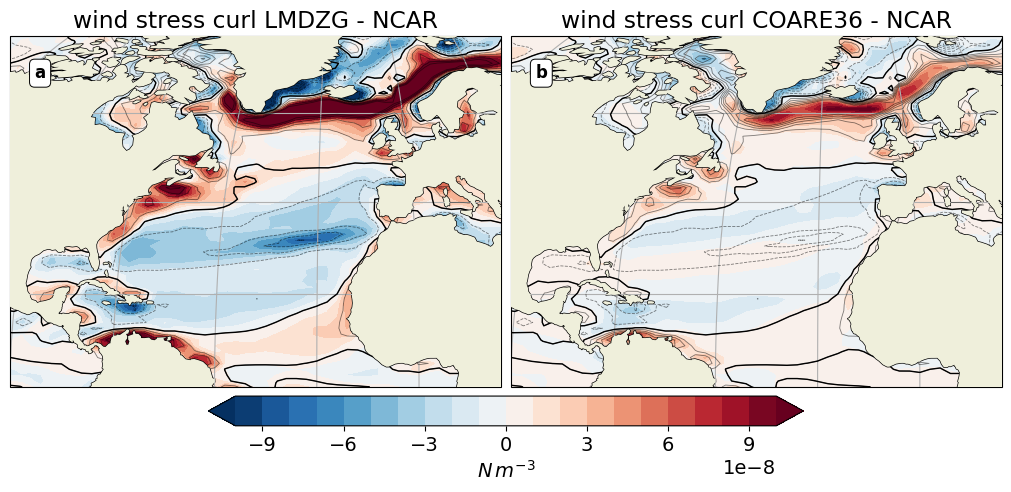

In [12]:
config = 'IPSLCM71';realm = 'ATM';bulk1 = 'NCAR'; i=0

fig,axs = plt.subplots(1, 2, subplot_kw={'projection': ccrs.Robinson(central_longitude=-20)}, figsize=(10,5))
levels = np.linspace(-1,1,21) *2e2 ; cmap= 'RdBu_r'
scale = 2 ; labels = ['a','b','c','d'] ; i=0
bulk_list_copy = bulk_list.copy() ; bulk_list_copy.pop(bulk1); bulk_list_copy.pop('LMDZNG'); bulk_list_copy.pop('ECMWF')

wind_norm = (load_data_ext(config,realm,bulk1,'u10m')**2 + load_data_ext(config,realm,bulk1,'v10m')**2)**0.5
u_factor = load_data_ext(config,realm,bulk1,'u10m') / wind_norm
v_factor = load_data_ext(config,realm,bulk1,'v10m') / wind_norm

taux = (offline_v1[bulk1]['tau'].fillna(0) * u_factor)
tauy = (offline_v1[bulk1]['tau'].fillna(0) * v_factor)
w = windspharm.xarray.VectorWind(taux, tauy)
curl_ref = w.vorticity().rolling(lon=scale, lat = scale, center=True, min_periods=1).mean().mean('month')
curl_ref, lon_cyc = add_cyclic_point(curl_ref, coord=curl_ref.lon)

for ax in (axs.flatten()):
    ax.coastlines(); ax.gridlines(draw_labels=False); ax.add_feature(cartopy.feature.LAND,zorder=10)
    ax.set_extent([-100, 20, 0, 80], crs=ccrs.PlateCarree())
    ax.text(0.05, 0.92, labels[i],  zorder= 12,  bbox=dict(facecolor='white', edgecolor='black',boxstyle='round,pad=0.3',linewidth=0.7),
     transform=ax.transAxes,  fontsize=12, fontweight='bold',va='top', ha='left')
    i +=1

for ax,bulk2 in zip(axs.flatten(),bulk_list_copy):
    ax.set_title('wind stress curl ' + bulk2 + ' - ' + bulk1)

    # Curl of wind stress
    # ======================
    taux = (offline_v1[bulk2]['tau'].fillna(0) * u_factor)
    tauy = (offline_v1[bulk2]['tau'].fillna(0) * v_factor)
    w = windspharm.xarray.VectorWind(taux, tauy)
    curl = w.vorticity().rolling(lon=scale, lat = scale, center=True, min_periods=1).mean().mean('month')
    curl, lon_cyc = add_cyclic_point(curl, coord=curl.lon)

    img_curl = ax.contourf(lon_cyc,taux.lat,np.flip(curl-curl_ref,axis=0),transform=ccrs.PlateCarree(),
                levels=np.linspace(-1,1,21) *1e-7,cmap= 'RdBu_r',extend='both')
    contour = ax.contour(lon_cyc,taux.lat,np.flip(curl_ref,axis=0),transform=ccrs.PlateCarree(),
                levels=np.linspace(-1,1,11) *4e-7,colors= 'k',alpha=0.5,linewidths=0.6)
    contour0 = ax.contour(lon_cyc,taux.lat,np.flip(curl_ref,axis=0),transform=ccrs.PlateCarree(),
                levels=[0],colors= 'k',linewidths=1)


fig.colorbar(img_curl, ax=axs,orientation='horizontal',label=r'$N\,m^{-3}$',shrink=0.6,pad=0.02)

# Final plot options
#-------------------------------------
title = 'Offline_Curl'
plt.savefig(save_path+title+'.png')

# Fig 13 (curl and gyres start)

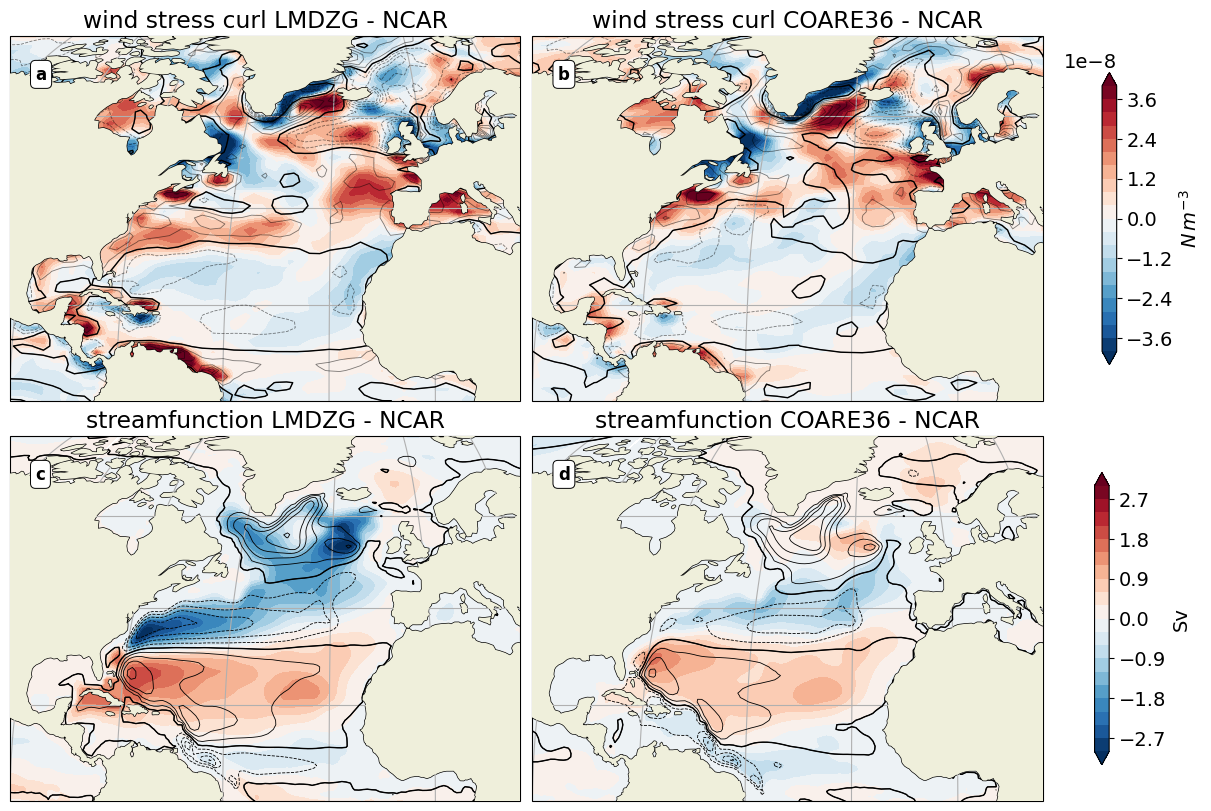

In [13]:
config = 'IPSLCM71';realm = 'ATM';bulk_ref = 'NCAR'; i=0

start_year, end_year = 1870, 1900
fig,axs = plt.subplots(2, 2, subplot_kw={'projection': ccrs.Robinson(central_longitude=-20)}, figsize=(12,8))
levels = np.linspace(-1,1,21) *2e2 ; cmap= 'RdBu_r'
scale = 2 ; labels = ['a','b','c','d'] ; i=0

ux = xr.open_dataset('CM71/CM71_TS_1850_1899/CM71'+bulk_ref+'_18500101_18991231_1M_uo_yr_mean.nc').uo.sel(time_counter=slice(str(start_year), str(end_year))).mean('time_counter').rename({'depthu':'z'})
psi_ref = nemo.bsf(ux,ORCA1_cfg.e2u*ORCA1_cfg.e3u_0,mask= ORCA1_weights>0,nperio=0, bsf0={'x':5, 'y':300} ).isel(t=0) / 1e6

u_ref = xr.concat([load_ts('1850_1899', bulk_ref,'taux'),load_ts('1900_1949', bulk_ref,'taux')], dim='time_counter').groupby('time_counter.year').mean().sel(year=slice(start_year, end_year)).mean('year')
v_ref = xr.concat([load_ts('1850_1899', bulk_ref,'tauy'),load_ts('1900_1949', bulk_ref,'tauy')], dim='time_counter').groupby('time_counter.year').mean().sel(year=slice(start_year, end_year)).mean('year')
w = windspharm.xarray.VectorWind(u_ref, v_ref)
curl_ref = w.vorticity().rolling(lon=scale, lat=scale, center=True, min_periods=1).mean()
curl_ref, lon_cyc = add_cyclic_point(curl_ref, coord=curl_ref.lon)

ux = load_data_ext(config, 'OCE', bulk_ref, 'uo', 'T', 'U').rename({'depth':'z'})
psi_ref_end = nemo.bsf(ux,ORCA1_cfg.e2u*ORCA1_cfg.e3u_0,mask= ORCA1_weights>0,nperio=0, bsf0={'x':5, 'y':300} ).mean('month').isel(t=0) / 1e6

u_ref = load_data_ext('IPSLCM71',realm, bulk_ref, 'taux').mean('month')
v_ref = load_data_ext('IPSLCM71',realm, bulk_ref, 'tauy').mean('month')
w = windspharm.xarray.VectorWind(u_ref, v_ref)
curl_ref_end = w.vorticity().rolling(lon=scale, lat=scale, center=True, min_periods=1).mean()
curl_ref_end, lon_cyc = add_cyclic_point(curl_ref_end, coord=curl_ref_end.lon)

for ax in (axs.flatten()):
    ax.coastlines(); ax.gridlines(draw_labels=False); ax.add_feature(cartopy.feature.LAND,zorder=10)
    ax.set_extent([-100, 20, 0, 80], crs=ccrs.PlateCarree())
    ax.text(0.05, 0.92, labels[i],  zorder= 12,  bbox=dict(facecolor='white', edgecolor='black',boxstyle='round,pad=0.3',linewidth=0.7),
     transform=ax.transAxes,  fontsize=12, fontweight='bold',va='top', ha='left')
    i +=1

for ax_cols,bulk in zip(axs.T,['LMDZG','COARE36']):

    # Curl of wind stress
    # ======================
    ax = ax_cols[0] ; ax.set_title('wind stress curl ' + bulk + ' - ' + bulk_ref)
    u = xr.concat([load_ts('1850_1899', bulk,'taux'),load_ts('1900_1949', bulk,'taux')], dim='time_counter').groupby('time_counter.year').mean().sel(year=slice(start_year, end_year)).mean('year')
    v = xr.concat([load_ts('1850_1899', bulk,'tauy'),load_ts('1900_1949', bulk,'tauy')], dim='time_counter').groupby('time_counter.year').mean().sel(year=slice(start_year, end_year)).mean('year')
    w = windspharm.xarray.VectorWind(u, v)
    curl = w.vorticity().rolling(lon=scale, lat=scale, center=True, min_periods=1).mean()
    curl, lon_cyc = add_cyclic_point(curl, coord=curl.lon)
    img_curl = ax.contourf(lon_cyc,u.lat,np.flip(curl-curl_ref,axis=0),transform=ccrs.PlateCarree(),
                levels=np.linspace(-1,1,21) *4e-8,cmap= 'RdBu_r',extend='both')

    u = load_data_ext('IPSLCM71',realm, bulk, 'taux').mean('month')
    v = load_data_ext('IPSLCM71',realm, bulk, 'tauy').mean('month')
    w = windspharm.xarray.VectorWind(u, v)
    curl = w.vorticity().rolling(lon=scale, lat=scale, center=True, min_periods=1).mean()
    curl, lon_cyc = add_cyclic_point(curl, coord=curl.lon)

    contour = ax.contour(lon_cyc,u.lat,np.flip(curl-curl_ref_end,axis=0),transform=ccrs.PlateCarree(),
                levels=np.linspace(-1,1,11) *4e-8,colors= 'k',alpha=0.5,linewidths=0.6)
    contour0 = ax.contour(lon_cyc,u.lat,np.flip(curl-curl_ref_end,axis=0),transform=ccrs.PlateCarree(),
                levels=[0],colors= 'k',linewidths=1)

    # Streamfunction
    # ======================
    ax = ax_cols[1] ; ax.set_title('streamfunction ' + bulk + ' - ' + bulk_ref)
    ux = xr.open_dataset('CM71/CM71_TS_1850_1899/CM71'+bulk+'_18500101_18991231_1M_uo_yr_mean.nc').uo.sel(time_counter=slice(str(start_year), str(end_year))).mean('time_counter').rename({'depthu':'z'})
    psi =  nemo.bsf(ux,ORCA1_cfg.e2u*ORCA1_cfg.e3u_0,mask= ORCA1_weights>0,nperio=0, bsf0={'x':5, 'y':300} ).isel(t=0) / 1e6
    lon,lat = nemo.fixed_lon(ux.nav_lon),ux.nav_lat
    img_sf = ax.contourf(lon,lat,psi-psi_ref,transform=ccrs.PlateCarree(),cmap='RdBu_r',levels=np.linspace(-3,3,21),extend='both')

    ux = load_data_ext(config, 'OCE', bulk, 'uo', 'T', 'U').rename({'depth':'z'})
    psi = nemo.bsf(ux,ORCA1_cfg.e2u*ORCA1_cfg.e3u_0,mask=ORCA1_weights>0,nperio=0, bsf0={'x':5, 'y':300} ).mean('month').isel(t=0) / 1e6
    lon,lat = nemo.fixed_lon(ux.nav_lon),ux.nav_lat
    contour = ax.contour(lon,lat,psi-psi_ref_end,transform=ccrs.PlateCarree(),levels=np.linspace(-3,3,11),
                        colors='k',linewidths=0.6)
    contour0 = ax.contour(lon,lat,psi-psi_ref_end,transform=ccrs.PlateCarree(),levels=[0], colors='k',linewidths=1)

fig.colorbar(img_curl, ax=axs[0],orientation='vertical',label=r'$N\,m^{-3}$',shrink=0.8,pad=0.02)
fig.colorbar(img_sf,ax=axs[1],orientation='vertical',shrink=0.8,label='Sv')

# Final plot options
#-------------------------------------
title = 'CurlGyreStart'
plt.savefig(save_path+title+'.png')

# Table 1 (freshwater)

In [53]:
Vtransport = xr.open_dataset('CM71/CM71_TS_2250_2299/CM71NCAR_18500101_22991231_1M_msftyz_atl.nc').isel(x=0).msftyz_atl[-12*100:].mean('time_counter')[0]
y30 = (abs(Vtransport.nav_lat - 30)).argmin() ; y45 = (abs(Vtransport.nav_lat - 45)).argmin() ; y60 = (abs(Vtransport.nav_lat - 60)).argmin()
y65 = (abs(Vtransport.nav_lat - 65)).argmin() ; y70 = (abs(Vtransport.nav_lat - 70)).argmin(); y75 = (abs(Vtransport.nav_lat - 75)).argmin()

In [54]:
# ax = plt.gca() ; ax.grid()
sref = 35 # g kg-1
nb_years = 150
salt_transport = {}; volume_transport= {}; fw_transport = {}; wfo = {}

for bulk,c in bulk_list.items(): 
    wfo[bulk] = xr.concat([ load_ts('2150_2199', bulk,'wfo'),load_ts('2200_2249', bulk,'wfo'),load_ts('2250_2299', bulk,'wfo')], dim='time_counter'
                            ).where(subbasins_mask.atlmsk).groupby('time_counter.year').mean('time_counter')[-nb_years:] /rho_eau  # m s-1
    salt_transport[bulk] = 1e9 * (xr.open_dataset('CM71/CM71_TS_2250_2299/CM71'+bulk+'_18500101_22991231_1M_sltadv.nc').sltadv+ 
                        xr.open_dataset('CM71/CM71_TS_2250_2299/CM71'+bulk+'_18500101_22991231_1M_sltldf.nc').sltldf+
                        xr.open_dataset('CM71/CM71_TS_2250_2299/CM71'+bulk+'_18500101_22991231_1M_sltbasinpmadv.nc').sltbasinpmadv
                        ).isel(x=0).sel(basin=2).groupby('time_counter.year').mean('time_counter')[-nb_years:]  # g s-1
    volume_transport[bulk] = xr.open_dataset('CM71/CM71_TS_2250_2299/CM71'+bulk+'_18500101_22991231_1M_msftyz_atl.nc').isel(depthw=0).isel(x=0).msftyz_atl.groupby('time_counter.year').mean('time_counter')[-nb_years:]
    volume_transport[bulk] =  -1e6 * volume_transport[bulk] # Convert to m3 s-1 (northward)
    fw_transport[bulk] = -(volume_transport[bulk] - salt_transport[bulk] / (sref * rho_eau) ) / 1e3 # mSv of freshwater (southward)
    fw_transport[bulk] = fw_transport[bulk].where(fw_transport[bulk].nav_lat > -10)


In [20]:
for bulk in bulk_list:
    print( bulk)

    # Drift of total volume (m3 s-1)
    Vdrift = ((load_data('IPSLCM71', 'OCE',bulk, 'zos') - load_data('IPSLCM71', 'OCE', bulk, 'zos','2250_2299','2200_2249')).mean('month').where(subbasins_mask.atlmsk).where((ORCA1_weights.nav_lat >= 60) & (ORCA1_weights.nav_lat <= 70)) * ORCA1_weights).sum() / (100 * 365 * 86400)
    print('Volume drift (m3 s-1):', Vdrift.values)

    # Drift of salt mass (g/s)
    e3t = load_data_ext('IPSLCM71', 'OCE', bulk, 'e3t').mean('month')
    Msdrift = ((load_data('IPSLCM71', 'OCE', bulk, 'so') * load_data('IPSLCM71', 'OCE', bulk, 'rhopoto') - load_data('IPSLCM71', 'OCE', bulk, 'so','2250_2299','2200_2249') * load_data('IPSLCM71', 'OCE', bulk, 'rhopoto','2250_2299','2200_2249')
                ).mean('month').where(subbasins_mask.atlmsk).where((ORCA1_weights.nav_lat >= 60) & (ORCA1_weights.nav_lat <= 70))  * ORCA1_weights * e3t).sum() / (100 * 365 * 86400) 
    print('Salt mass drift (g/s):', Msdrift.values)

    # Drift of freshwater (mSv)
    FWdrift = (Vdrift - Msdrift / (sref * rho_eau) ) / 1e3
    print('Freshwater drift (mSv):', FWdrift.values)

NCAR
Volume drift (m3 s-1): -26.395714
Salt mass drift (g/s): 9354257.0
Freshwater drift (mSv): -0.28714156
LMDZNG
Volume drift (m3 s-1): -41.67098
Salt mass drift (g/s): 26891398.0
Freshwater drift (mSv): -0.79125696
LMDZG
Volume drift (m3 s-1): -46.2844
Salt mass drift (g/s): 13349284.0
Freshwater drift (mSv): -0.41838986
ECMWF
Volume drift (m3 s-1): -28.44215
Salt mass drift (g/s): 21281314.0
Freshwater drift (mSv): -0.6216495
COARE36
Volume drift (m3 s-1): -25.235256
Salt mass drift (g/s): 22588298.0
Freshwater drift (mSv): -0.6548742


In [19]:
for bulk in bulk_list:
    print( bulk)

    # Drift of total volume (m3 s-1)
    Vdrift = ((load_data('IPSLCM71', 'OCE',bulk, 'zos') - load_data('IPSLCM71', 'OCE', bulk, 'zos','2250_2299','2200_2249')).mean('month').where(subbasins_mask.atlmsk).where((ORCA1_weights.nav_lat >= 45) & (ORCA1_weights.nav_lat <= 60)) * ORCA1_weights).sum() / (100 * 365 * 86400)
    print('Volume drift (m3 s-1):', Vdrift.values)

    # Drift of salt mass (g/s)
    e3t = load_data_ext('IPSLCM71', 'OCE', bulk, 'e3t').mean('month')
    Msdrift = ((load_data('IPSLCM71', 'OCE', bulk, 'so') * load_data('IPSLCM71', 'OCE', bulk, 'rhopoto') - load_data('IPSLCM71', 'OCE', bulk, 'so','2250_2299','2200_2249') * load_data('IPSLCM71', 'OCE', bulk, 'rhopoto','2250_2299','2200_2249')
                ).mean('month').where(subbasins_mask.atlmsk).where((ORCA1_weights.nav_lat >= 45) & (ORCA1_weights.nav_lat <= 60))  * ORCA1_weights * e3t).sum() / (100 * 365 * 86400) 
    print('Salt mass drift (g/s):', Msdrift.values)

    # Drift of freshwater (mSv)
    FWdrift = (Vdrift - Msdrift / (sref * rho_eau) ) / 1e3
    print('Freshwater drift (mSv):', FWdrift.values)

NCAR
Volume drift (m3 s-1): -42.895695
Salt mass drift (g/s): 45319270.0
Freshwater drift (mSv): -1.3061508
LMDZNG
Volume drift (m3 s-1): -56.498825
Salt mass drift (g/s): 8680191.0
Freshwater drift (mSv): -0.2984554
LMDZG
Volume drift (m3 s-1): -71.59875
Salt mass drift (g/s): -8445987.0
Freshwater drift (mSv): 0.16382946
ECMWF
Volume drift (m3 s-1): -19.80576
Salt mass drift (g/s): 45595660.0
Freshwater drift (mSv): -1.2907649
COARE36
Volume drift (m3 s-1): -53.29107
Salt mass drift (g/s): 62066984.0
Freshwater drift (mSv): -1.7833811


In [56]:
import numpy as np
import scipy.stats as stats

# =====================================================
# Vérification et initialisation
# =====================================================
# Trouve les indices les plus proches de 45°, 60°, 70°N
y45 = int(np.abs(fw_transport['NCAR'].nav_lat - 45).argmin())
y60 = int(np.abs(fw_transport['NCAR'].nav_lat - 60).argmin())
y70 = int(np.abs(fw_transport['NCAR'].nav_lat - 70).argmin())

n_years = len(fw_transport[next(iter(bulk_list))])

# Dictionnaires de résultats
div_45_60 = {}
div_60_70 = {}
surf_flux_45_60 = {}
surf_flux_60_70 = {}

# =====================================================
# Calculs des divergences et bilans
# =====================================================
# -> Divergence = F(φ_sud) - F(φ_nord)
#    (positif = gain net d’eau douce dans la bande)
# -> Les flux de surface sont intégrés sur chaque boîte
#    et comparés à la divergence du transport méridien.
# =====================================================

for bulk in bulk_list:
    fw = fw_transport[bulk]

    # --- Transport d’eau douce aux latitudes clés
    F45 = fw.isel(y=y45).values
    F60 = fw.isel(y=y60).values
    F70 = fw.isel(y=y70).values

    # --- Divergences entre bandes latitudinales
    div_45_60[bulk] = F45 - F60     # 45–60°N
    div_60_70[bulk] = F60 - F70     # 60–70°N

    # --- Flux de surface d’eau douce sur les mêmes boîtes
    surf_flux_45_60[bulk] = (
        (-wfo[bulk] * ORCA1_weights)
        .where((ORCA1_weights.nav_lat >= 45) & (ORCA1_weights.nav_lat <= 60))
        .weighted(subbasins_mask.atlmsk)
        .sum(['x', 'y'])
        .values / 1e3  # mSv
    )

    surf_flux_60_70[bulk] = (
        (-wfo[bulk] * ORCA1_weights)
        .where((ORCA1_weights.nav_lat > 60) & (ORCA1_weights.nav_lat <= 70))
        .weighted(subbasins_mask.atlmsk)
        .sum(['x', 'y'])
        .values / 1e3  # mSv
    )

    # =====================================================
    # Cas de référence : NCAR
    # =====================================================
    if bulk == 'NCAR':
        print(f"\n{bulk} (référence)")

        for lat, F in zip(['45°N', '60°N', '70°N'], [F45, F60, F70]):
            print(f"  Transport à {lat}: {np.mean(F):.1f} ± {np.std(F)/np.sqrt(n_years):.1f} mSv")

        print(f"  Divergence 45–60°N : {np.mean(div_45_60[bulk]):.1f} ± {np.std(div_45_60[bulk])/np.sqrt(n_years):.1f} mSv")
        print(f"  Divergence 60–70°N : {np.mean(div_60_70[bulk]):.1f} ± {np.std(div_60_70[bulk])/np.sqrt(n_years):.1f} mSv")

        print(f"  Surface flux 45–60°N : {np.mean(surf_flux_45_60[bulk]):.1f} ± {np.std(surf_flux_45_60[bulk])/np.sqrt(n_years):.1f} mSv")
        print(f"  Surface flux 60–70°N : {np.mean(surf_flux_60_70[bulk]):.1f} ± {np.std(surf_flux_60_70[bulk])/np.sqrt(n_years):.1f} mSv")

        bilan_45_60 = -div_45_60[bulk] + surf_flux_45_60[bulk]
        bilan_60_70 = -div_60_70[bulk] + surf_flux_60_70[bulk]

        print(f"  Bilan net 45–60°N : {np.mean(bilan_45_60):.1f} ± {np.std(bilan_45_60)/np.sqrt(n_years):.1f} mSv")
        print(f"  Bilan net 60–70°N : {np.mean(bilan_60_70):.1f} ± {np.std(bilan_60_70)/np.sqrt(n_years):.1f} mSv")

    # =====================================================
    # Autres expériences
    # =====================================================
    else:
        print(f"\n{bulk} (vs NCAR)")

        # Différences de transport à chaque latitude
        for lat, Fy, Fy_ref in zip(
            ['45°N', '60°N', '70°N'],
            [F45, F60, F70],
            [fw_transport['NCAR'].isel(y=y45).values,
             fw_transport['NCAR'].isel(y=y60).values,
             fw_transport['NCAR'].isel(y=y70).values]
        ):
            diff = np.mean(Fy - Fy_ref)
            pval = stats.ttest_ind(Fy_ref, Fy, axis=0, equal_var=False).pvalue
            print(f"  Δ{lat}: {diff:+.1f} mSv (p={pval:.3f})")

        # Différences de divergences
        ddiv_45_60 = np.mean(div_45_60[bulk] - div_45_60['NCAR'])
        ddiv_60_70 = np.mean(div_60_70[bulk] - div_60_70['NCAR'])
        p45_60 = stats.ttest_ind(div_45_60['NCAR'], div_45_60[bulk], axis=0, equal_var=False).pvalue
        p60_70 = stats.ttest_ind(div_60_70['NCAR'], div_60_70[bulk], axis=0, equal_var=False).pvalue

        print(f"  Δ(45–60°N): {ddiv_45_60:+.1f} mSv (p={p45_60:.3f})")
        print(f"  Δ(60–70°N): {ddiv_60_70:+.1f} mSv (p={p60_70:.3f})")

        # Différences de flux de surface
        dsurf_45_60 = np.mean(surf_flux_45_60[bulk] - surf_flux_45_60['NCAR'])
        dsurf_60_70 = np.mean(surf_flux_60_70[bulk] - surf_flux_60_70['NCAR'])
        p45_60 = stats.ttest_ind(surf_flux_45_60['NCAR'], surf_flux_45_60[bulk], axis=0, equal_var=False).pvalue
        p60_70 = stats.ttest_ind(surf_flux_60_70['NCAR'], surf_flux_60_70[bulk], axis=0, equal_var=False).pvalue

        print(f"  ΔFlux surf. 45–60°N: {dsurf_45_60:+.1f} mSv (p={p45_60:.3f})")
        print(f"  ΔFlux surf. 60–70°N: {dsurf_60_70:+.1f} mSv (p={p60_70:.3f})")
        
        bilan_45_60 = -div_45_60[bulk] + surf_flux_45_60[bulk]
        bilan_60_70 = -div_60_70[bulk] + surf_flux_60_70[bulk]

        print(f"  Bilan net 45–60°N : {np.mean(bilan_45_60):.1f} ± {np.std(bilan_45_60)/np.sqrt(n_years):.1f} mSv")
        print(f"  Bilan net 60–70°N : {np.mean(bilan_60_70):.1f} ± {np.std(bilan_60_70)/np.sqrt(n_years):.1f} mSv")



NCAR (référence)
  Transport à 45°N: 583.1 ± 3.9 mSv
  Transport à 60°N: 364.8 ± 2.7 mSv
  Transport à 70°N: 252.0 ± 2.8 mSv
  Divergence 45–60°N : 218.3 ± 5.1 mSv
  Divergence 60–70°N : 112.8 ± 3.0 mSv
  Surface flux 45–60°N : 239.7 ± 1.1 mSv
  Surface flux 60–70°N : 92.0 ± 0.9 mSv
  Bilan net 45–60°N : 21.3 ± 4.8 mSv
  Bilan net 60–70°N : -20.7 ± 3.0 mSv

LMDZNG (vs NCAR)
  Δ45°N: -8.8 mSv (p=0.140)
  Δ60°N: -10.5 mSv (p=0.010)
  Δ70°N: -12.0 mSv (p=0.003)
  Δ(45–60°N): +1.7 mSv (p=0.820)
  Δ(60–70°N): +1.5 mSv (p=0.736)
  ΔFlux surf. 45–60°N: +3.6 mSv (p=0.029)
  ΔFlux surf. 60–70°N: +1.4 mSv (p=0.263)
  Bilan net 45–60°N : 23.2 ± 5.5 mSv
  Bilan net 60–70°N : -20.8 ± 3.2 mSv

LMDZG (vs NCAR)
  Δ45°N: -16.1 mSv (p=0.008)
  Δ60°N: -14.8 mSv (p=0.000)
  Δ70°N: -14.5 mSv (p=0.000)
  Δ(45–60°N): -1.4 mSv (p=0.857)
  Δ(60–70°N): -0.2 mSv (p=0.956)
  ΔFlux surf. 45–60°N: +1.6 mSv (p=0.320)
  ΔFlux surf. 60–70°N: +1.8 mSv (p=0.139)
  Bilan net 45–60°N : 24.3 ± 5.4 mSv
  Bilan net 60–70°N 

# Table 2 (heat)

In [ ]:
for bulk in bulk_list:
    print( bulk)

    # Drift of heat(PW)
    e3t = load_data_ext('IPSLCM71', 'OCE', bulk, 'e3t').mean('month')
    Msdrift = ((load_data('IPSLCM71', 'OCE', bulk, 'thetao') * load_data('IPSLCM71', 'OCE', bulk, 'rhopoto') - load_data('IPSLCM71', 'OCE', bulk, 'thetao','2250_2299','2200_2249') * load_data('IPSLCM71', 'OCE', bulk, 'rhopoto','2250_2299','2200_2249')
                ).mean('month').where(subbasins_mask.atlmsk).where((ORCA1_weights.nav_lat >= 60) & (ORCA1_weights.nav_lat <= 70)) * Cp_eau * ORCA1_weights * e3t).sum() / (100 * 365 * 86400) /1e12
    print('Heat drift (PW):', Msdrift.values)


NCAR
Heat drift (PW): 0.43216178
LMDZNG
Heat drift (PW): 0.25036967
LMDZG
Heat drift (PW): -0.16466202
ECMWF
Heat drift (PW): 0.79194576
COARE36
Heat drift (PW): 0.96566117


In [ ]:
for bulk in bulk_list:
    print( bulk)

    # Drift of heat(PW)
    e3t = load_data_ext('IPSLCM71', 'OCE', bulk, 'e3t').mean('month')
    Msdrift = ((load_data('IPSLCM71', 'OCE', bulk, 'thetao') * load_data('IPSLCM71', 'OCE', bulk, 'rhopoto') - load_data('IPSLCM71', 'OCE', bulk, 'thetao','2250_2299','2200_2249') * load_data('IPSLCM71', 'OCE', bulk, 'rhopoto','2250_2299','2200_2249')
                ).mean('month').where(subbasins_mask.atlmsk).where((ORCA1_weights.nav_lat >= 45) & (ORCA1_weights.nav_lat <= 60)) * Cp_eau * ORCA1_weights * e3t).sum() / (100 * 365 * 86400) /1e12
    print('Heat drift (PW):', Msdrift.values)


NCAR
Heat drift (PW): 1.8949909
LMDZNG
Heat drift (PW): 0.5112487
LMDZG
Heat drift (PW): -0.315864
ECMWF
Heat drift (PW): 2.7927184
COARE36
Heat drift (PW): 2.3615339


## Surface 

In [ ]:
QT_OCE_45_60 = {} ; QT_OCE_60_70 = {} 
for bulk,color in bulk_list.items():
    ds = xr.concat([ load_ts('2150_2199', bulk,'qt_oce'),load_ts('2200_2249', bulk,'qt_oce'),load_ts('2250_2299', bulk,'qt_oce')], dim='time_counter').groupby('time_counter.year').mean('time_counter')
    ds += load_data_ext('IPSLCM71','OCE',bulk,'qt_ice').mean('month') + load_data_ext('IPSLCM71','OCE',bulk,'qemp_oce').mean('month')
    QT_OCE_45_60[bulk] = np.round( (ds.where((ORCA1_weights.nav_lat >= 45 )& (ORCA1_weights.nav_lat <= 60)) * ORCA1_weights).weighted(subbasins_mask.atlmsk).sum(['x','y']).values /1e12,2)
    QT_OCE_60_70[bulk] = np.round( (ds.where((ORCA1_weights.nav_lat >= 60 )& (ORCA1_weights.nav_lat <= 70)) * ORCA1_weights).weighted(subbasins_mask.atlmsk).sum(['x','y']).values /1e12,2)



In [ ]:
n_years = len(QT_OCE_45_60[bulk])
for bulk in bulk_list:
    if bulk == 'NCAR':
        print(bulk, '45-60°N', np.round(np.mean(QT_OCE_45_60[bulk]),1), np.round(np.std(QT_OCE_45_60[bulk])/np.sqrt(n_years),1))
        print(bulk, '60-70°N', np.round(np.mean(QT_OCE_60_70[bulk]),1), np.round(np.std(QT_OCE_60_70[bulk])/np.sqrt(n_years),1))
   
    else:
        print(bulk, '45-60°N', np.round(np.mean(QT_OCE_45_60[bulk] -  QT_OCE_45_60['NCAR']),1),  np.round(scipy.stats.ttest_ind(QT_OCE_45_60['NCAR'], QT_OCE_45_60[bulk], axis=0,equal_var=False).pvalue,3))
        print(bulk, '60-70°N', np.round(np.mean(QT_OCE_60_70[bulk] -  QT_OCE_60_70['NCAR']),1),  np.round(scipy.stats.ttest_ind(QT_OCE_60_70['NCAR'], QT_OCE_60_70[bulk], axis=0,equal_var=False).pvalue,3))


NCAR 45-60°N -62.2 3.0
NCAR 60-70°N -155.9 1.4
LMDZNG 45-60°N 16.3 0.0
LMDZNG 60-70°N 4.9 0.008
LMDZG 45-60°N 25.8 0.0
LMDZG 60-70°N 8.4 0.0
ECMWF 45-60°N 26.5 0.0
ECMWF 60-70°N 10.5 0.0
COARE36 45-60°N 36.4 0.0
COARE36 60-70°N 7.5 0.0


## Transport

In [ ]:
basin = 2 ; nb_year = 150
heat_transport_45 = {} ; heat_transport_60 = {} ; heat_transport_70 = {}
for bulk,color in bulk_list.items():
    heat_transport_45[bulk] = np.round(1e3 * (xr.open_dataset('CM71/CM71_TS_2250_2299/CM71'+bulk+'_18500101_22991231_1M_htldf.nc').htldf + xr.open_dataset('CM71/CM71_TS_2250_2299/CM71'+bulk+'_18500101_22991231_1M_htadv.nc').htadv + xr.open_dataset('CM71/CM71_TS_2250_2299/CM71'+bulk+'_18500101_22991231_1M_hfbasinpmadv.nc').hfbasinpmadv).sel(basin=basin).isel(x=0).isel(y=y45)[-12*nb_year:].groupby('time_counter.year').mean('time_counter').values,2) # TW
    heat_transport_60[bulk] = np.round(1e3 * (xr.open_dataset('CM71/CM71_TS_2250_2299/CM71'+bulk+'_18500101_22991231_1M_htldf.nc').htldf + xr.open_dataset('CM71/CM71_TS_2250_2299/CM71'+bulk+'_18500101_22991231_1M_htadv.nc').htadv + xr.open_dataset('CM71/CM71_TS_2250_2299/CM71'+bulk+'_18500101_22991231_1M_hfbasinpmadv.nc').hfbasinpmadv).sel(basin=basin).isel(x=0).isel(y=y60)[-12*nb_year:].groupby('time_counter.year').mean('time_counter').values,2) # TW
    heat_transport_70[bulk] = np.round(1e3 * (xr.open_dataset('CM71/CM71_TS_2250_2299/CM71'+bulk+'_18500101_22991231_1M_htldf.nc').htldf + xr.open_dataset('CM71/CM71_TS_2250_2299/CM71'+bulk+'_18500101_22991231_1M_htadv.nc').htadv + xr.open_dataset('CM71/CM71_TS_2250_2299/CM71'+bulk+'_18500101_22991231_1M_hfbasinpmadv.nc').hfbasinpmadv).sel(basin=basin).isel(x=0).isel(y=y70)[-12*nb_year:].groupby('time_counter.year').mean('time_counter').values,2) # TW
    


In [ ]:
n_years = len(heat_transport_45[bulk])
div_45_60 = {} ; div_60_70 = {}

for bulk in bulk_list:
    div_45_60[bulk] = heat_transport_45[bulk]-heat_transport_60[bulk]
    div_60_70[bulk] = heat_transport_60[bulk]-heat_transport_70[bulk]

    if bulk == 'NCAR':
        print(bulk, '45°N', np.round(np.mean(heat_transport_45[bulk]),1), np.round(np.std(heat_transport_45[bulk])/np.sqrt(n_years),1))
        print(bulk, '60°N', np.round(np.mean(heat_transport_60[bulk]),1), np.round(np.std(heat_transport_60[bulk])/np.sqrt(n_years),1))
        print(bulk, '70°N', np.round(np.mean(heat_transport_70[bulk]),1), np.round(np.std(heat_transport_70[bulk])/np.sqrt(n_years),1))

        print(bulk, '45-60°N', np.round(np.mean(div_45_60[bulk]),1),
                    np.round(np.std((div_45_60[bulk]))/np.sqrt(n_years),1))
        print(bulk, '60-70°N', np.round(np.mean(div_60_70[bulk]),1),
                    np.round(np.std((div_60_70[bulk]))/np.sqrt(n_years),1))

    else:
        print(bulk, '45°N', np.round(np.mean(heat_transport_45[bulk] -  heat_transport_45['NCAR']),1),  np.round(scipy.stats.ttest_ind(heat_transport_45['NCAR'], heat_transport_45[bulk], axis=0,equal_var=False).pvalue,3))
        print(bulk, '60°N', np.round(np.mean(heat_transport_60[bulk] -  heat_transport_60['NCAR']),1),  np.round(scipy.stats.ttest_ind(heat_transport_60['NCAR'], heat_transport_60[bulk], axis=0,equal_var=False).pvalue,3))
        print(bulk, '70°N', np.round(np.mean(heat_transport_70[bulk] -  heat_transport_70['NCAR']),1),  np.round(scipy.stats.ttest_ind(heat_transport_70['NCAR'], heat_transport_70[bulk], axis=0,equal_var=False).pvalue,3))
    
        print(bulk, '45-60°N', np.round(np.mean(div_45_60[bulk]-div_45_60['NCAR']),1),
                    np.round(scipy.stats.ttest_ind(div_45_60['NCAR'], div_45_60[bulk], axis=0,equal_var=False).pvalue,3) )
        print(bulk, '60-70°N', np.round(np.mean(div_60_70[bulk]-div_60_70['NCAR']),1),
                    np.round(scipy.stats.ttest_ind(div_60_70['NCAR'], div_60_70[bulk], axis=0,equal_var=False).pvalue,3) )
        

NCAR 45°N 383.2 2.1
NCAR 60°N 300.5 1.8
NCAR 70°N 155.2 1.6
NCAR 45-60°N 82.7 2.7
NCAR 60-70°N 145.4 1.8
LMDZNG 45°N -31.6 0.0
LMDZNG 60°N -13.6 0.0
LMDZNG 70°N -9.0 0.0
LMDZNG 45-60°N -18.0 0.0
LMDZNG 60-70°N -4.6 0.064
LMDZG 45°N -45.1 0.0
LMDZG 60°N -17.5 0.0
LMDZG 70°N -8.6 0.0
LMDZG 45-60°N -27.7 0.0
LMDZG 60-70°N -8.8 0.001
ECMWF 45°N -51.9 0.0
ECMWF 60°N -24.1 0.0
ECMWF 70°N -14.4 0.0
ECMWF 45-60°N -27.8 0.0
ECMWF 60-70°N -9.7 0.001
COARE36 45°N -60.0 0.0
COARE36 60°N -20.6 0.0
COARE36 70°N -11.7 0.0
COARE36 45-60°N -39.4 0.0
COARE36 60-70°N -8.9 0.001
